### Dados retidados dos repositórios:
* https://github.com/aatishb/covid
* https://github.com/CSSEGISandData/COVID-19

# Tracking the Growth of COVID-19 Cases

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')


## Global COVID-19 Analysis

In [3]:
cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
print('\nTotal number of cases (in countries with at least 100 cases) as of', mostrecentdate)

cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]
cases


Total number of cases (in countries with at least 100 cases) as of 5/8/20


5/8/20
Country/Region              
US                   1283929
Spain                 222857
Italy                 217185
United Kingdom        212629
Russia                187859
...                      ...
Cambodia                 122
South Sudan              120
Trinidad and Tobago      116
Nepal                    102
Uganda                   101

[149 rows x 1 columns]

## Curve Fitting Global COVID-19 Cases

In [4]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Original Data")
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.95:
            plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.95:
            plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit")
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            
    except:
        pass
    
    plt.title(country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]



US

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 1283929
	Confirmed cases on 5/1/20 	 1103461
	Ratio: 1.16
	Weekly increase: 16.4 %
	Daily increase: 2.2 % per day
	Doubling Time (represents recent growth): 32.0 days

** Based on Logistic Fit**

	R^2: 0.9968871539866616
	Doubling Time (during middle of growth):  13.05 (± 0.67 ) days


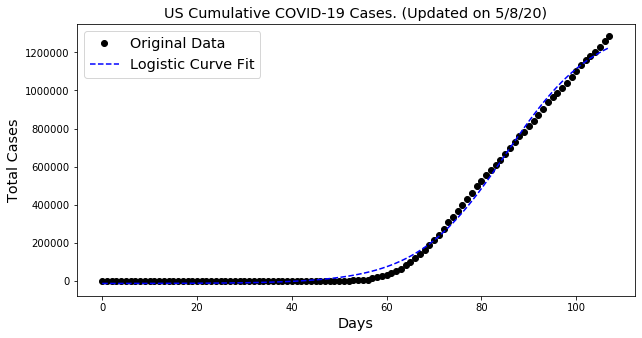



Spain

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 222857
	Confirmed cases on 5/1/20 	 213435
	Ratio: 1.04
	Weekly increase: 4.4 %
	Daily increase: 0.6 % per day
	Doubling Time (represents recent growth): 112.3 days

** Based on Logistic Fit**

	R^2: 0.9981111156717898
	Doubling Time (during middle of growth):  9.79 (± 0.4 ) days


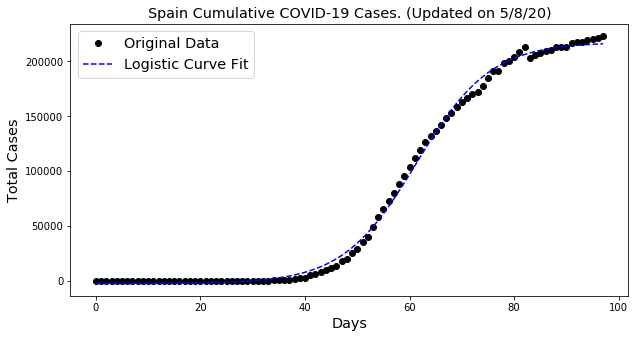



Italy

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 217185
	Confirmed cases on 5/1/20 	 207428
	Ratio: 1.05
	Weekly increase: 4.7 %
	Daily increase: 0.7 % per day
	Doubling Time (represents recent growth): 105.6 days

** Based on Logistic Fit**

	R^2: 0.9970273476380899
	Doubling Time (during middle of growth):  13.98 (± 0.71 ) days


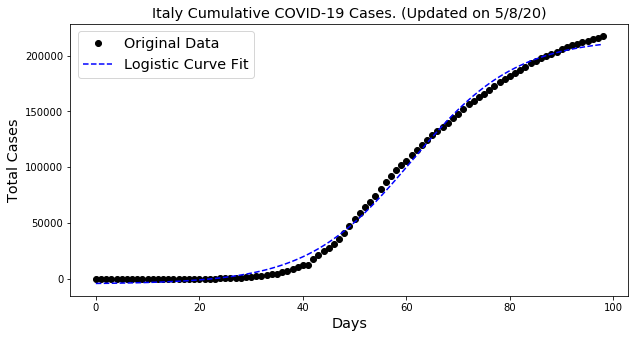



United Kingdom

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 212629
	Confirmed cases on 5/1/20 	 178685
	Ratio: 1.19
	Weekly increase: 19.0 %
	Daily increase: 2.5 % per day
	Doubling Time (represents recent growth): 27.9 days

** Based on Logistic Fit**

	R^2: 0.9974907430174393
	Doubling Time (during middle of growth):  13.11 (± 0.64 ) days


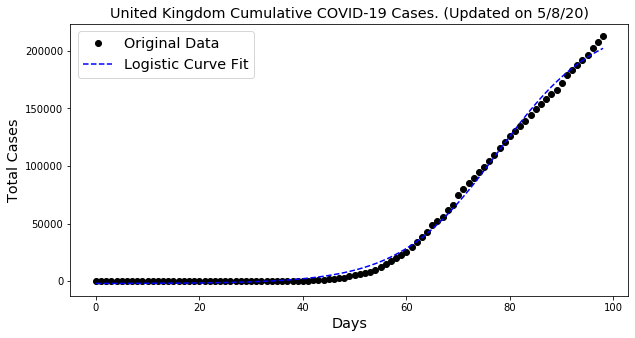



Russia

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 187859
	Confirmed cases on 5/1/20 	 114431
	Ratio: 1.64
	Weekly increase: 64.2 %
	Daily increase: 7.3 % per day
	Doubling Time (represents recent growth): 9.8 days

** Based on Logistic Fit**

	R^2: 0.9986320493317639
	Doubling Time (during middle of growth):  11.56 (± 0.47 ) days

** Based on Exponential Fit **

	R^2: 0.9919997202027834
	Doubling Time (represents overall growth):  8.24 (± 0.32 ) days


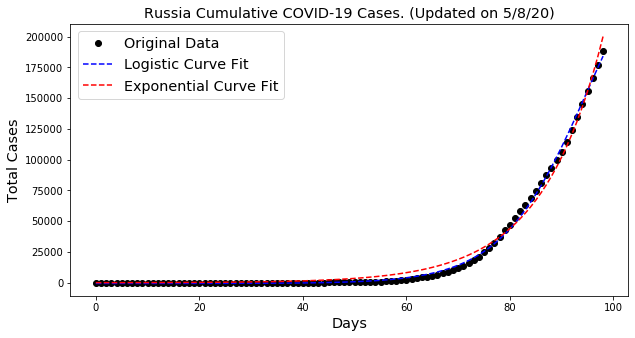



France

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 176202
	Confirmed cases on 5/1/20 	 167305
	Ratio: 1.05
	Weekly increase: 5.3 %
	Daily increase: 0.7 % per day
	Doubling Time (represents recent growth): 93.6 days

** Based on Logistic Fit**

	R^2: 0.9973197418488836
	Doubling Time (during middle of growth):  10.08 (± 0.47 ) days


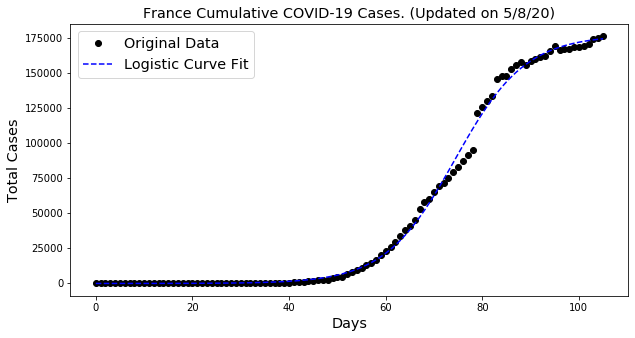



Germany

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 170588
	Confirmed cases on 5/1/20 	 164077
	Ratio: 1.04
	Weekly increase: 4.0 %
	Daily increase: 0.6 % per day
	Doubling Time (represents recent growth): 124.7 days

** Based on Logistic Fit**

	R^2: 0.9980439652311176
	Doubling Time (during middle of growth):  10.1 (± 0.41 ) days


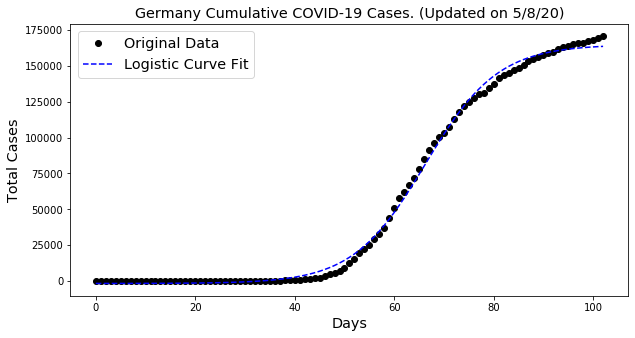



Brazil

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 146894
	Confirmed cases on 5/1/20 	 92202
	Ratio: 1.59
	Weekly increase: 59.3 %
	Daily increase: 6.9 % per day
	Doubling Time (represents recent growth): 10.4 days

** Based on Logistic Fit**

	R^2: 0.9989985904748311
	Doubling Time (during middle of growth):  17.66 (± 0.97 ) days

** Based on Exponential Fit **

	R^2: 0.9523162185004126
	Doubling Time (represents overall growth):  6.72 (± 0.72 ) days


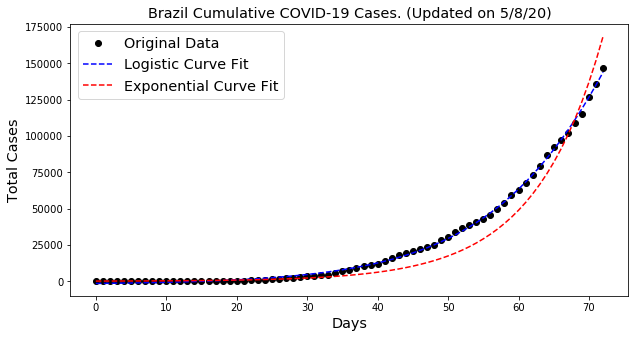



Turkey

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 135569
	Confirmed cases on 5/1/20 	 122392
	Ratio: 1.11
	Weekly increase: 10.8 %
	Daily increase: 1.5 % per day
	Doubling Time (represents recent growth): 47.5 days

** Based on Logistic Fit**

	R^2: 0.9991828849468919
	Doubling Time (during middle of growth):  10.6 (± 0.39 ) days


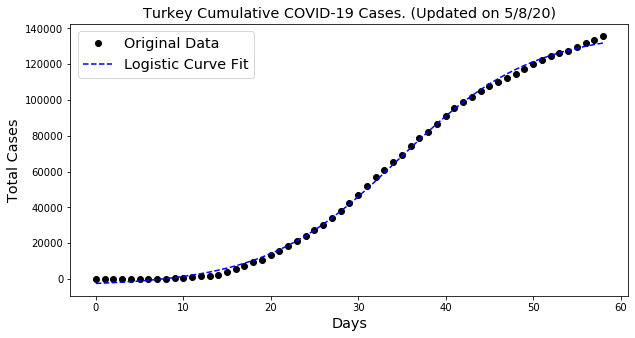



Iran

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 104691
	Confirmed cases on 5/1/20 	 95646
	Ratio: 1.09
	Weekly increase: 9.5 %
	Daily increase: 1.3 % per day
	Doubling Time (represents recent growth): 53.7 days

** Based on Logistic Fit**

	R^2: 0.9981794132979217
	Doubling Time (during middle of growth):  15.27 (± 0.74 ) days


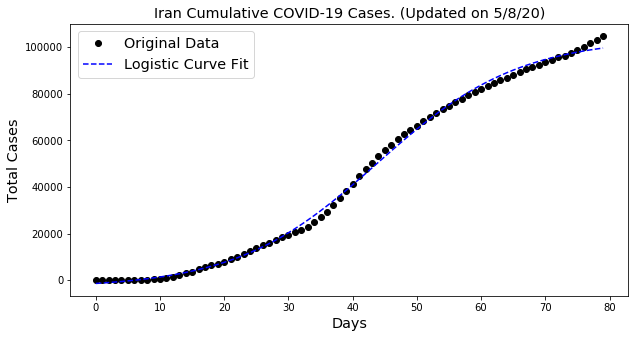



China

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 83976
	Confirmed cases on 5/1/20 	 83959
	Ratio: 1.0
	Weekly increase: 0.0 %
	Daily increase: 0.0 % per day
	Doubling Time (represents recent growth): 23965.5 days

** Based on Logistic Fit**

	R^2: 0.9952786933389225
	Doubling Time (during middle of growth):  6.88 (± 0.44 ) days


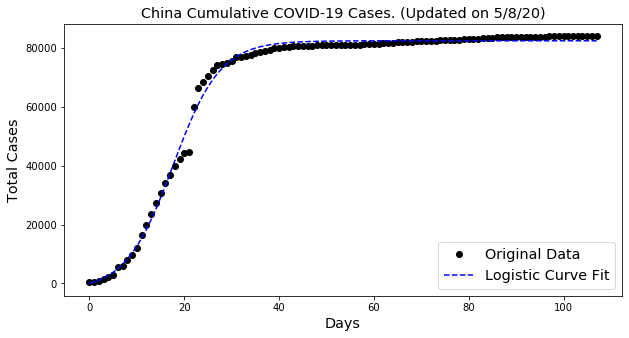



Canada

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 67674
	Confirmed cases on 5/1/20 	 56343
	Ratio: 1.2
	Weekly increase: 20.1 %
	Daily increase: 2.7 % per day
	Doubling Time (represents recent growth): 26.5 days

** Based on Logistic Fit**

	R^2: 0.997848648384255
	Doubling Time (during middle of growth):  14.1 (± 0.64 ) days


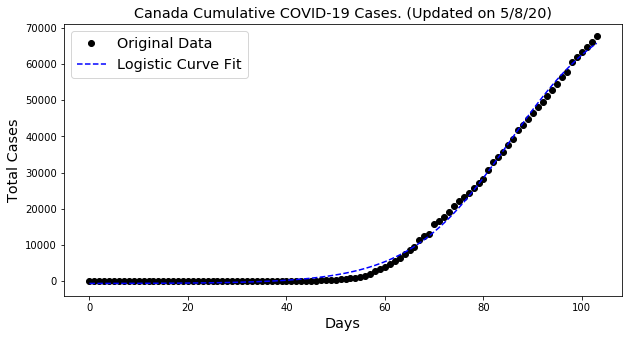



Peru

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 61847
	Confirmed cases on 5/1/20 	 40459
	Ratio: 1.53
	Weekly increase: 52.9 %
	Daily increase: 6.3 % per day
	Doubling Time (represents recent growth): 11.4 days

** Based on Logistic Fit**

	R^2: 0.9983961895429069
	Doubling Time (during middle of growth):  13.91 (± 0.92 ) days

** Based on Exponential Fit **

	R^2: 0.9585469870874281
	Doubling Time (represents overall growth):  6.63 (± 0.73 ) days


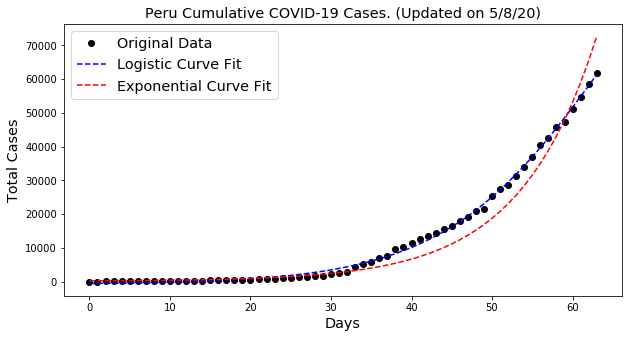



India

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 59695
	Confirmed cases on 5/1/20 	 37257
	Ratio: 1.6
	Weekly increase: 60.2 %
	Daily increase: 7.0 % per day
	Doubling Time (represents recent growth): 10.3 days

** Based on Logistic Fit**

	R^2: 0.9976119683889808
	Doubling Time (during middle of growth):  15.16 (± 0.87 ) days

** Based on Exponential Fit **

	R^2: 0.9937069930243666
	Doubling Time (represents overall growth):  9.6 (± 0.33 ) days


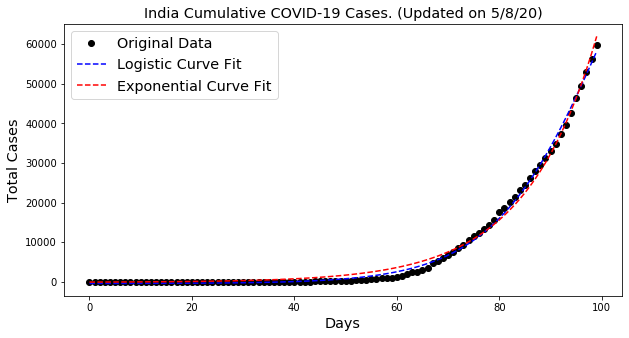



Belgium

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 52011
	Confirmed cases on 5/1/20 	 49032
	Ratio: 1.06
	Weekly increase: 6.1 %
	Daily increase: 0.8 % per day
	Doubling Time (represents recent growth): 82.3 days

** Based on Logistic Fit**

	R^2: 0.9987274556899657
	Doubling Time (during middle of growth):  11.58 (± 0.39 ) days


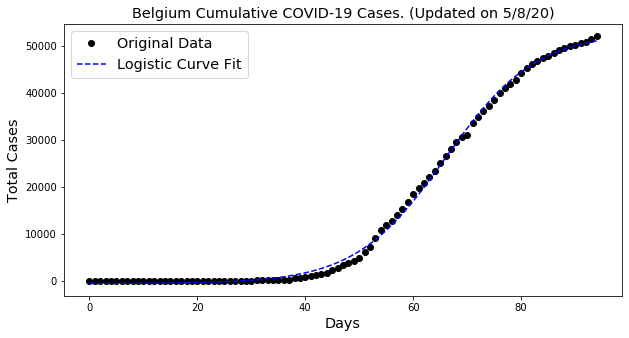



Netherlands

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 42292
	Confirmed cases on 5/1/20 	 39989
	Ratio: 1.06
	Weekly increase: 5.8 %
	Daily increase: 0.8 % per day
	Doubling Time (represents recent growth): 86.7 days

** Based on Logistic Fit**

	R^2: 0.9990716492081183
	Doubling Time (during middle of growth):  13.02 (± 0.46 ) days


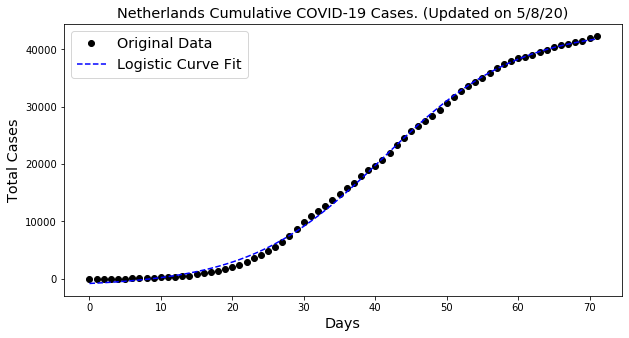



Saudi Arabia

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 35432
	Confirmed cases on 5/1/20 	 24097
	Ratio: 1.47
	Weekly increase: 47.0 %
	Daily increase: 5.7 % per day
	Doubling Time (represents recent growth): 12.6 days

** Based on Logistic Fit**

	R^2: 0.9993071814029696
	Doubling Time (during middle of growth):  12.26 (± 0.45 ) days

** Based on Exponential Fit **

	R^2: 0.9745091662850691
	Doubling Time (represents overall growth):  7.72 (± 0.67 ) days


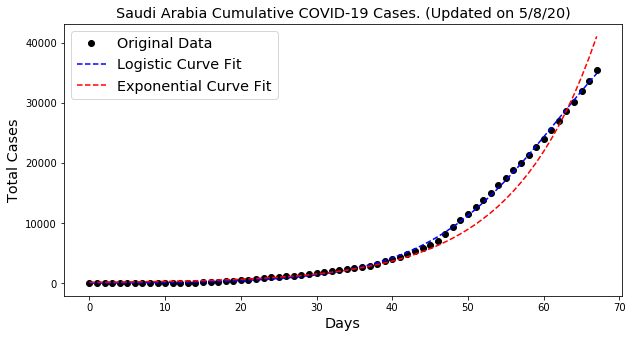



Mexico

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 31522
	Confirmed cases on 5/1/20 	 20739
	Ratio: 1.52
	Weekly increase: 52.0 %
	Daily increase: 6.2 % per day
	Doubling Time (represents recent growth): 11.6 days

** Based on Logistic Fit**

	R^2: 0.9996618415086433
	Doubling Time (during middle of growth):  14.63 (± 0.41 ) days

** Based on Exponential Fit **

	R^2: 0.9884165196606542
	Doubling Time (represents overall growth):  8.3 (± 0.48 ) days


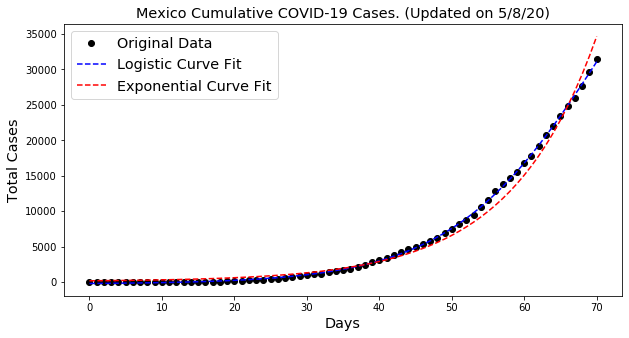



Switzerland

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 30207
	Confirmed cases on 5/1/20 	 29705
	Ratio: 1.02
	Weekly increase: 1.7 %
	Daily increase: 0.2 % per day
	Doubling Time (represents recent growth): 289.5 days

** Based on Logistic Fit**

	R^2: 0.9979603474195582
	Doubling Time (during middle of growth):  9.92 (± 0.47 ) days


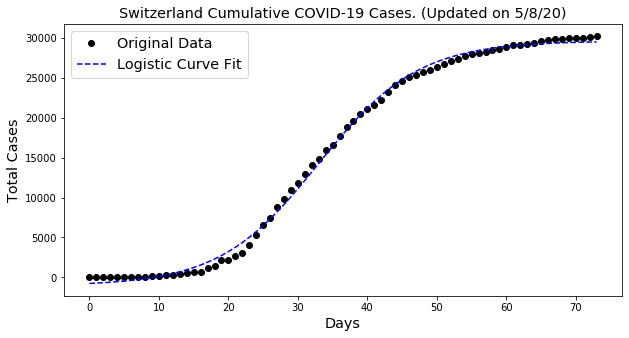



Ecuador

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 28818
	Confirmed cases on 5/1/20 	 26336
	Ratio: 1.09
	Weekly increase: 9.4 %
	Daily increase: 1.3 % per day
	Doubling Time (represents recent growth): 53.9 days

** Based on Logistic Fit**

	R^2: 0.9755305118794741
	Doubling Time (during middle of growth):  10.3 (± 2.0 ) days


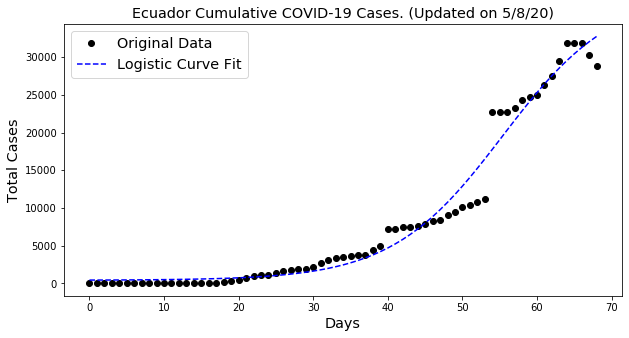



Portugal

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 27268
	Confirmed cases on 5/1/20 	 25351
	Ratio: 1.08
	Weekly increase: 7.6 %
	Daily increase: 1.0 % per day
	Doubling Time (represents recent growth): 66.6 days

** Based on Logistic Fit**

	R^2: 0.9975683639965188
	Doubling Time (during middle of growth):  12.01 (± 0.7 ) days


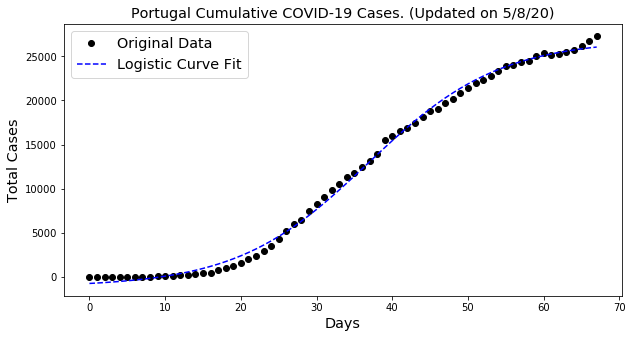



Pakistan

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 26435
	Confirmed cases on 5/1/20 	 18114
	Ratio: 1.46
	Weekly increase: 45.9 %
	Daily increase: 5.5 % per day
	Doubling Time (represents recent growth): 12.8 days

** Based on Logistic Fit**

	R^2: 0.9991167919095488
	Doubling Time (during middle of growth):  20.06 (± 1.12 ) days

** Based on Exponential Fit **

	R^2: 0.9778237383063171
	Doubling Time (represents overall growth):  8.78 (± 0.69 ) days


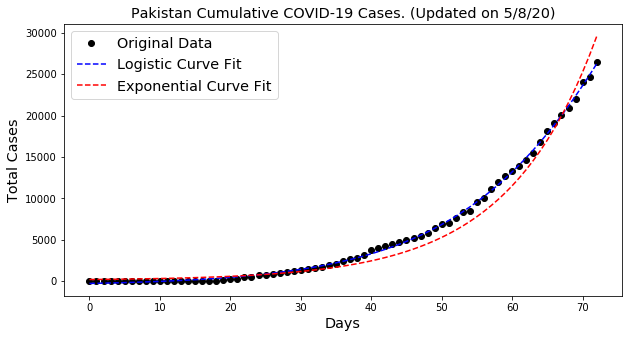



Chile

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 25972
	Confirmed cases on 5/1/20 	 17008
	Ratio: 1.53
	Weekly increase: 52.7 %
	Daily increase: 6.2 % per day
	Doubling Time (represents recent growth): 11.5 days

** Based on Logistic Fit**

	R^2: 0.9947282779902802
	Doubling Time (during middle of growth):  31.5 (± inf ) days


C:\OSGEO4~1\apps\Python37\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


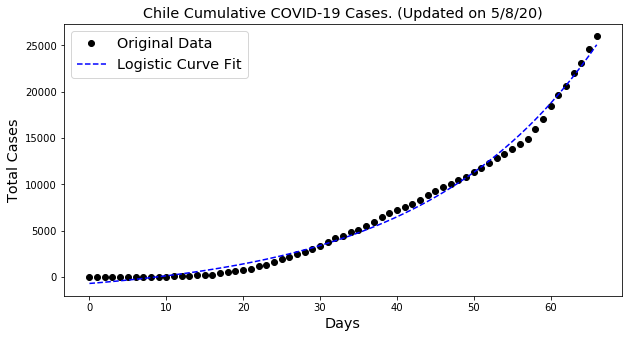



Sweden

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 25265
	Confirmed cases on 5/1/20 	 21520
	Ratio: 1.17
	Weekly increase: 17.4 %
	Daily increase: 2.3 % per day
	Doubling Time (represents recent growth): 30.2 days

** Based on Logistic Fit**

	R^2: 0.9989790308493507
	Doubling Time (during middle of growth):  16.21 (± 0.54 ) days


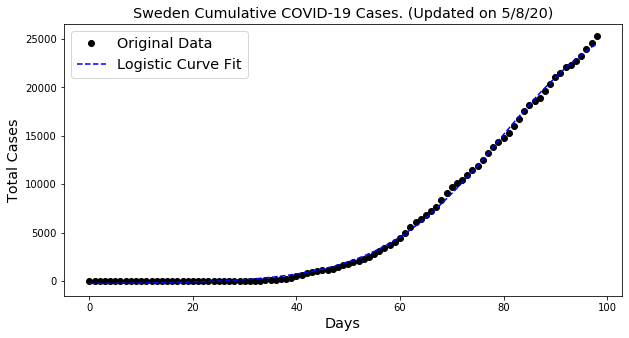



Ireland

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 22541
	Confirmed cases on 5/1/20 	 20833
	Ratio: 1.08
	Weekly increase: 8.2 %
	Daily increase: 1.1 % per day
	Doubling Time (represents recent growth): 61.6 days

** Based on Logistic Fit**

	R^2: 0.9990490498700256
	Doubling Time (during middle of growth):  10.55 (± 0.37 ) days


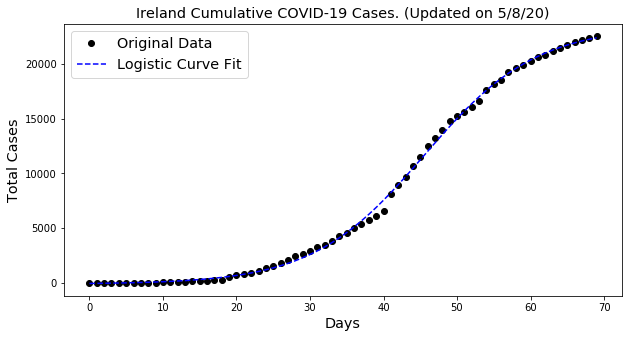



Singapore

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 21707
	Confirmed cases on 5/1/20 	 17101
	Ratio: 1.27
	Weekly increase: 26.9 %
	Daily increase: 3.5 % per day
	Doubling Time (represents recent growth): 20.3 days

** Based on Logistic Fit**

	R^2: 0.9980282385259489
	Doubling Time (during middle of growth):  8.4 (± 0.35 ) days

** Based on Exponential Fit **

	R^2: 0.9709793961749271
	Doubling Time (represents overall growth):  10.27 (± 0.75 ) days


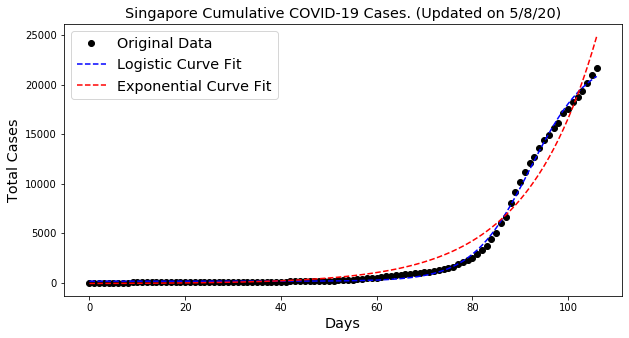



Belarus

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 21101
	Confirmed cases on 5/1/20 	 14917
	Ratio: 1.41
	Weekly increase: 41.5 %
	Daily increase: 5.1 % per day
	Doubling Time (represents recent growth): 14.0 days

** Based on Logistic Fit**

	R^2: 0.9989728771446151
	Doubling Time (during middle of growth):  10.62 (± 0.43 ) days

** Based on Exponential Fit **

	R^2: 0.9832161465272126
	Doubling Time (represents overall growth):  8.87 (± 0.65 ) days


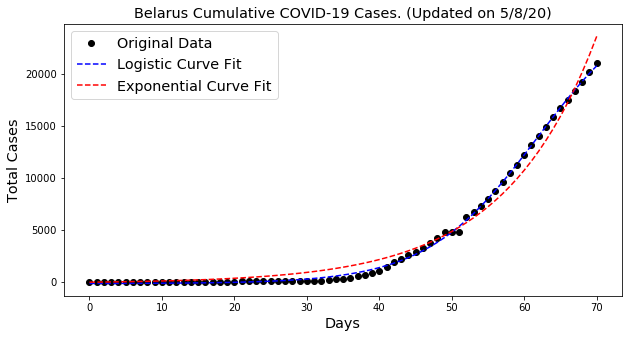



Qatar

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 20201
	Confirmed cases on 5/1/20 	 14096
	Ratio: 1.43
	Weekly increase: 43.3 %
	Daily increase: 5.3 % per day
	Doubling Time (represents recent growth): 13.5 days

** Based on Logistic Fit**

	R^2: 0.9991096182975757
	Doubling Time (during middle of growth):  12.4 (± 0.51 ) days

** Based on Exponential Fit **

	R^2: 0.9862102639538316
	Doubling Time (represents overall growth):  8.85 (± 0.58 ) days


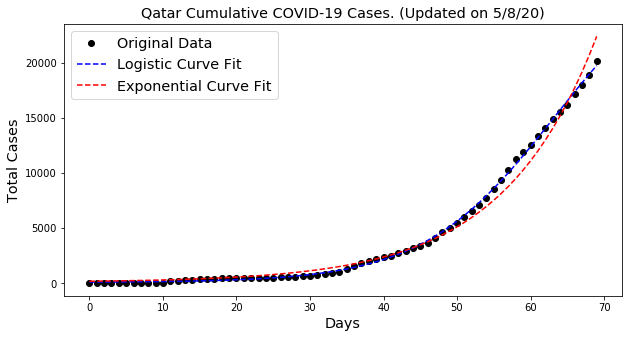



United Arab Emirates

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 16793
	Confirmed cases on 5/1/20 	 13038
	Ratio: 1.29
	Weekly increase: 28.8 %
	Daily increase: 3.7 % per day
	Doubling Time (represents recent growth): 19.2 days

** Based on Logistic Fit**

	R^2: 0.998326326658373
	Doubling Time (during middle of growth):  12.77 (± 0.53 ) days

** Based on Exponential Fit **

	R^2: 0.9800716988351329
	Doubling Time (represents overall growth):  11.7 (± 0.76 ) days


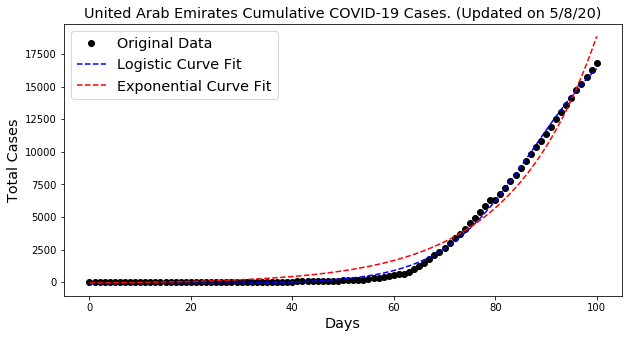



Israel

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 16436
	Confirmed cases on 5/1/20 	 16101
	Ratio: 1.02
	Weekly increase: 2.1 %
	Daily increase: 0.3 % per day
	Doubling Time (represents recent growth): 235.6 days

** Based on Logistic Fit**

	R^2: 0.9963810714645054
	Doubling Time (during middle of growth):  10.11 (± 0.63 ) days


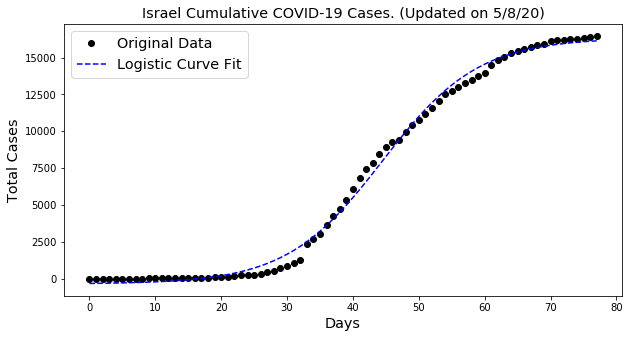



Austria

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 15774
	Confirmed cases on 5/1/20 	 15531
	Ratio: 1.02
	Weekly increase: 1.6 %
	Daily increase: 0.2 % per day
	Doubling Time (represents recent growth): 312.5 days

** Based on Logistic Fit**

	R^2: 0.997489448935239
	Doubling Time (during middle of growth):  7.79 (± 0.42 ) days


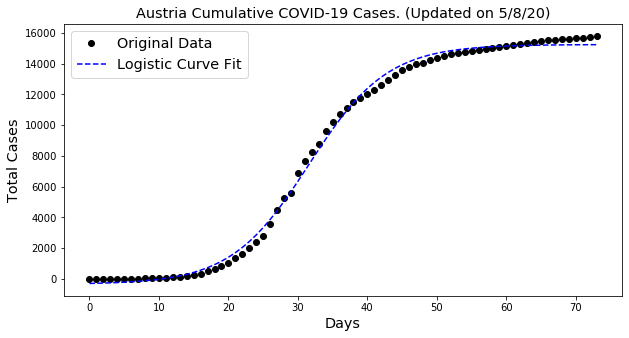



Japan

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 15575
	Confirmed cases on 5/1/20 	 14305
	Ratio: 1.09
	Weekly increase: 8.9 %
	Daily increase: 1.2 % per day
	Doubling Time (represents recent growth): 57.0 days

** Based on Logistic Fit**

	R^2: 0.9982295891724768
	Doubling Time (during middle of growth):  10.19 (± 0.39 ) days


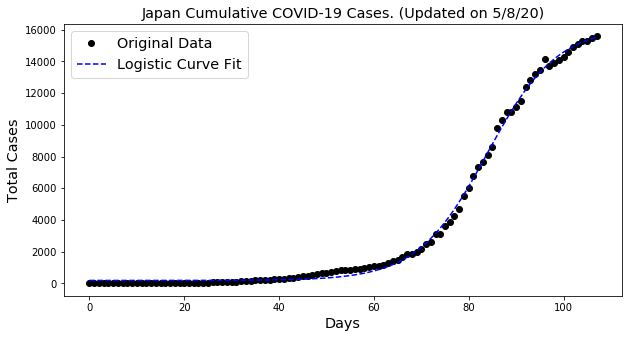



Poland

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 15366
	Confirmed cases on 5/1/20 	 13105
	Ratio: 1.17
	Weekly increase: 17.3 %
	Daily increase: 2.3 % per day
	Doubling Time (represents recent growth): 30.5 days

** Based on Logistic Fit**

	R^2: 0.9982486386974063
	Doubling Time (during middle of growth):  15.13 (± 0.91 ) days


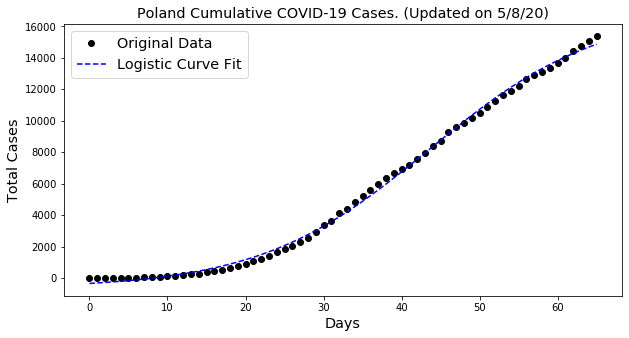



Romania

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 14811
	Confirmed cases on 5/1/20 	 12567
	Ratio: 1.18
	Weekly increase: 17.9 %
	Daily increase: 2.4 % per day
	Doubling Time (represents recent growth): 29.5 days

** Based on Logistic Fit**

	R^2: 0.9976912543488464
	Doubling Time (during middle of growth):  14.47 (± 0.87 ) days


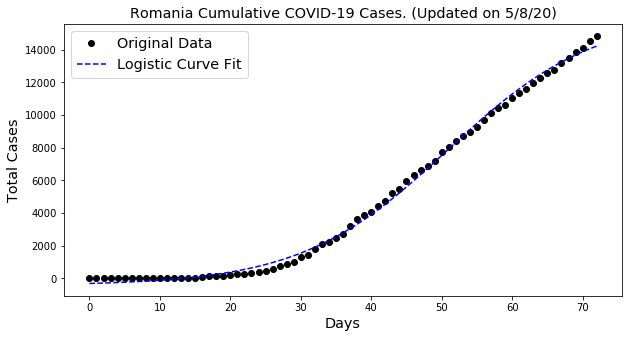



Ukraine

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 14195
	Confirmed cases on 5/1/20 	 10861
	Ratio: 1.31
	Weekly increase: 30.7 %
	Daily increase: 3.9 % per day
	Doubling Time (represents recent growth): 18.1 days

** Based on Logistic Fit**

	R^2: 0.9993866829223098
	Doubling Time (during middle of growth):  12.31 (± 0.41 ) days

** Based on Exponential Fit **

	R^2: 0.95535031479945
	Doubling Time (represents overall growth):  8.9 (± 1.1 ) days


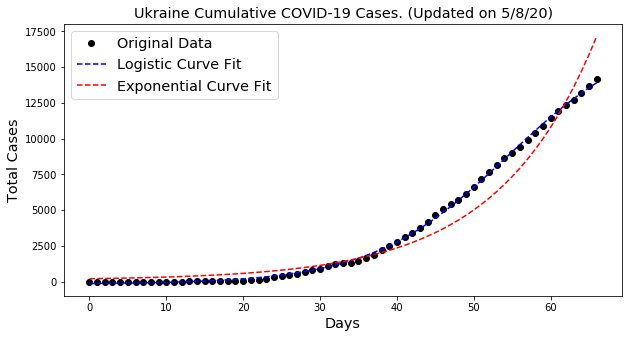



Bangladesh

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 13134
	Confirmed cases on 5/1/20 	 8238
	Ratio: 1.59
	Weekly increase: 59.4 %
	Daily increase: 6.9 % per day
	Doubling Time (represents recent growth): 10.4 days

** Based on Logistic Fit**

	R^2: 0.997981676695249
	Doubling Time (during middle of growth):  9.8 (± 0.62 ) days

** Based on Exponential Fit **

	R^2: 0.986109693638036
	Doubling Time (represents overall growth):  7.86 (± 0.56 ) days


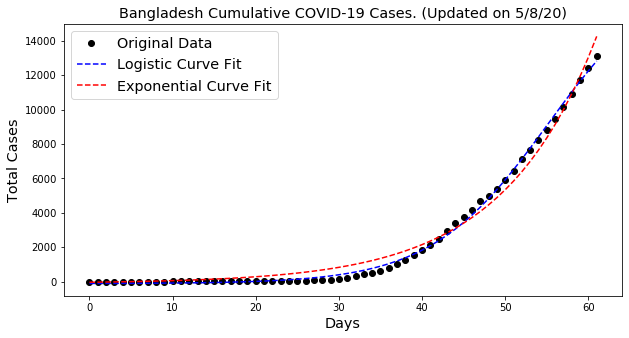



Indonesia

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 13112
	Confirmed cases on 5/1/20 	 10551
	Ratio: 1.24
	Weekly increase: 24.3 %
	Daily increase: 3.2 % per day
	Doubling Time (represents recent growth): 22.3 days

** Based on Logistic Fit**

	R^2: 0.9991607337842181
	Doubling Time (during middle of growth):  15.99 (± 0.7 ) days


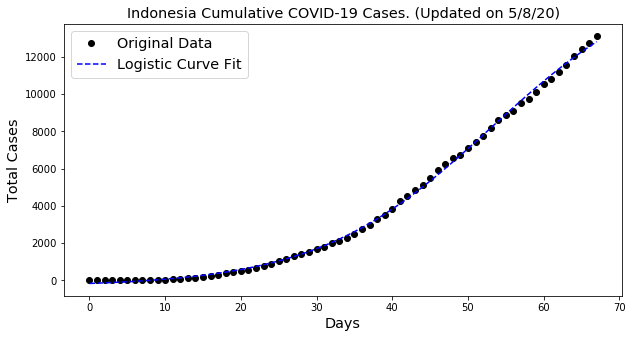



Korea, South

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 10840
	Confirmed cases on 5/1/20 	 10780
	Ratio: 1.01
	Weekly increase: 0.6 %
	Daily increase: 0.1 % per day
	Doubling Time (represents recent growth): 874.2 days

** Based on Logistic Fit**

	R^2: 0.9885960825877749
	Doubling Time (during middle of growth):  8.69 (± 0.87 ) days


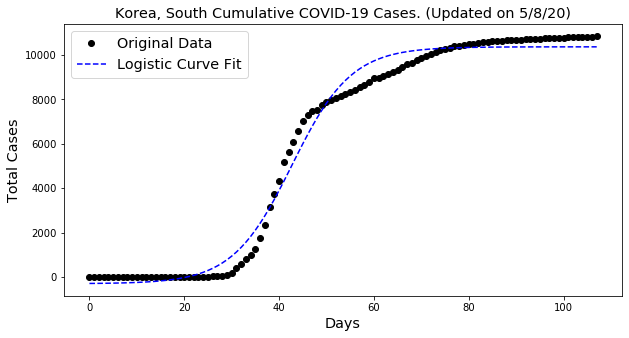



Philippines

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 10463
	Confirmed cases on 5/1/20 	 8772
	Ratio: 1.19
	Weekly increase: 19.3 %
	Daily increase: 2.6 % per day
	Doubling Time (represents recent growth): 27.5 days

** Based on Logistic Fit**

	R^2: 0.9930476682801083
	Doubling Time (during middle of growth):  14.46 (± 1.18 ) days


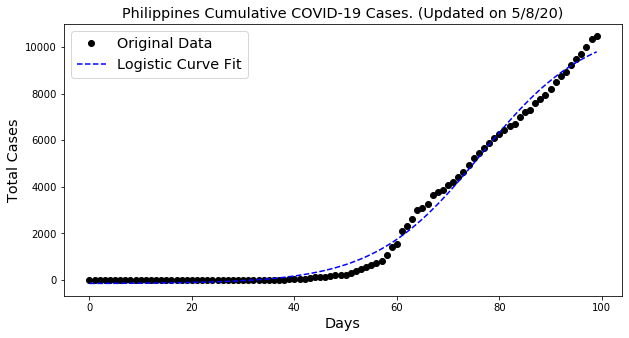



Denmark

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 10416
	Confirmed cases on 5/1/20 	 9509
	Ratio: 1.1
	Weekly increase: 9.5 %
	Daily increase: 1.3 % per day
	Doubling Time (represents recent growth): 53.3 days

** Based on Logistic Fit**

	R^2: 0.997672455964274
	Doubling Time (during middle of growth):  15.39 (± 0.95 ) days


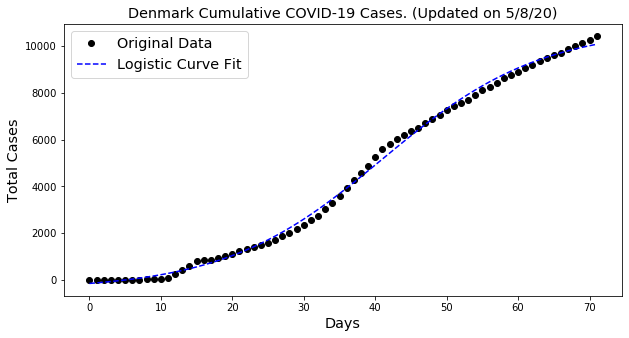



Colombia

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 10051
	Confirmed cases on 5/1/20 	 7006
	Ratio: 1.43
	Weekly increase: 43.5 %
	Daily increase: 5.3 % per day
	Doubling Time (represents recent growth): 13.4 days

** Based on Logistic Fit**

	R^2: 0.9974290380724764
	Doubling Time (during middle of growth):  28.9 (± 5.19 ) days

** Based on Exponential Fit **

	R^2: 0.9543902235736698
	Doubling Time (represents overall growth):  9.25 (± 1.18 ) days


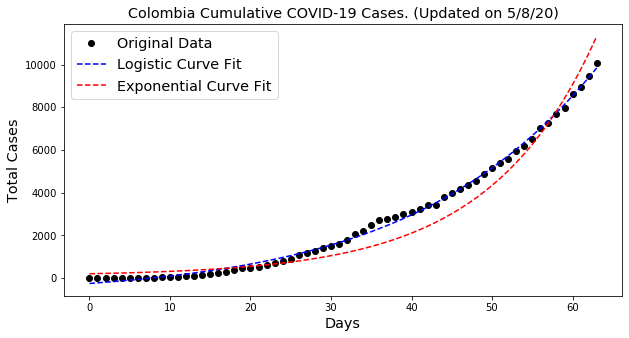



Serbia

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 9943
	Confirmed cases on 5/1/20 	 9009
	Ratio: 1.1
	Weekly increase: 10.4 %
	Daily increase: 1.4 % per day
	Doubling Time (represents recent growth): 49.2 days

** Based on Logistic Fit**

	R^2: 0.99936274162781
	Doubling Time (during middle of growth):  10.43 (± 0.32 ) days


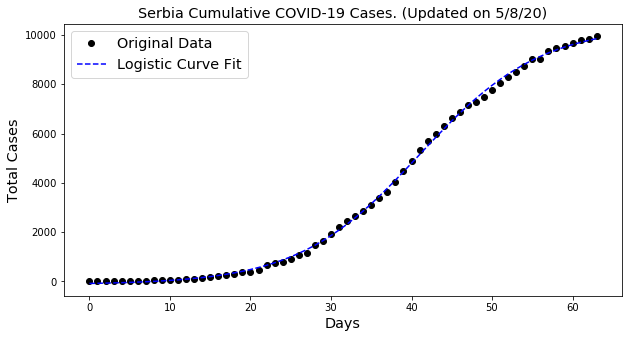



Dominican Republic

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 9376
	Confirmed cases on 5/1/20 	 7288
	Ratio: 1.29
	Weekly increase: 28.6 %
	Daily increase: 3.7 % per day
	Doubling Time (represents recent growth): 19.3 days

** Based on Logistic Fit**

	R^2: 0.9974607332838589
	Doubling Time (during middle of growth):  16.72 (± 1.3 ) days


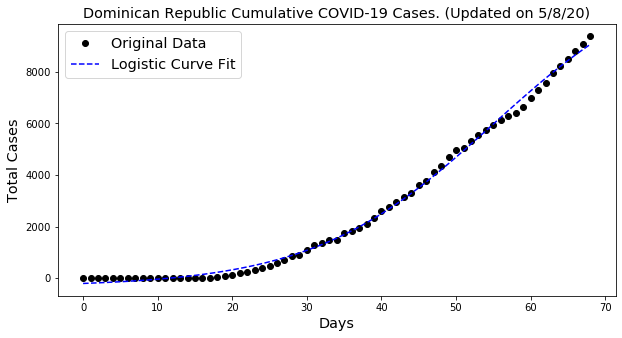



South Africa

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 8895
	Confirmed cases on 5/1/20 	 5951
	Ratio: 1.49
	Weekly increase: 49.5 %
	Daily increase: 5.9 % per day
	Doubling Time (represents recent growth): 12.1 days

** Based on Logistic Fit**

	R^2: 0.9948116409331053
	Doubling Time (during middle of growth):  29.59 (± 1.69 ) days

** Based on Exponential Fit **

	R^2: 0.9645988899756947
	Doubling Time (represents overall growth):  9.72 (± 1.08 ) days


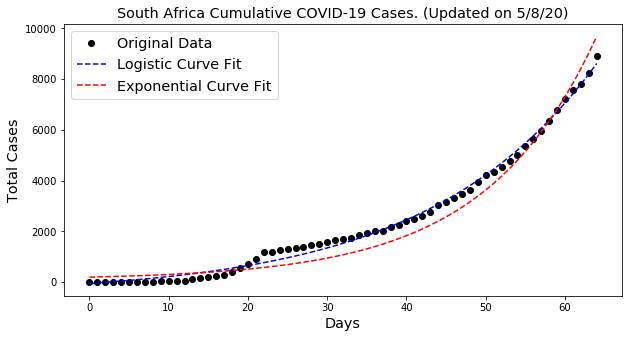



Egypt

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 8476
	Confirmed cases on 5/1/20 	 5895
	Ratio: 1.44
	Weekly increase: 43.8 %
	Daily increase: 5.3 % per day
	Doubling Time (represents recent growth): 13.4 days

** Based on Logistic Fit**

	R^2: 0.9987801051421138
	Doubling Time (during middle of growth):  20.04 (± 1.05 ) days

** Based on Exponential Fit **

	R^2: 0.99553842757546
	Doubling Time (represents overall growth):  12.34 (± 0.44 ) days


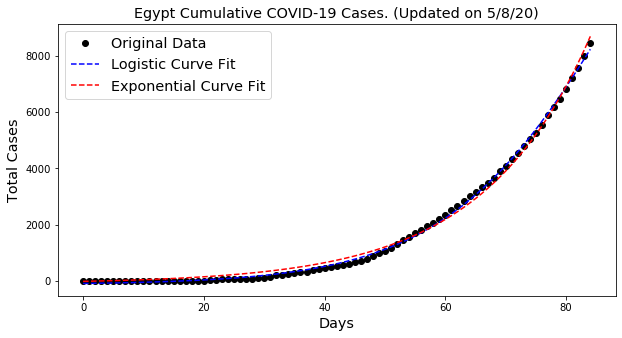



Czechia

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 8077
	Confirmed cases on 5/1/20 	 7737
	Ratio: 1.04
	Weekly increase: 4.4 %
	Daily increase: 0.6 % per day
	Doubling Time (represents recent growth): 112.8 days

** Based on Logistic Fit**

	R^2: 0.9976068156677887
	Doubling Time (during middle of growth):  11.01 (± 0.61 ) days


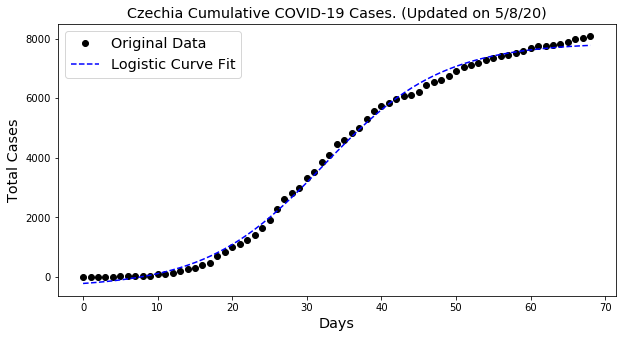



Panama

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 8070
	Confirmed cases on 5/1/20 	 6720
	Ratio: 1.2
	Weekly increase: 20.1 %
	Daily increase: 2.6 % per day
	Doubling Time (represents recent growth): 26.5 days

** Based on Logistic Fit**

	R^2: 0.998409255606789
	Doubling Time (during middle of growth):  18.03 (± 1.42 ) days


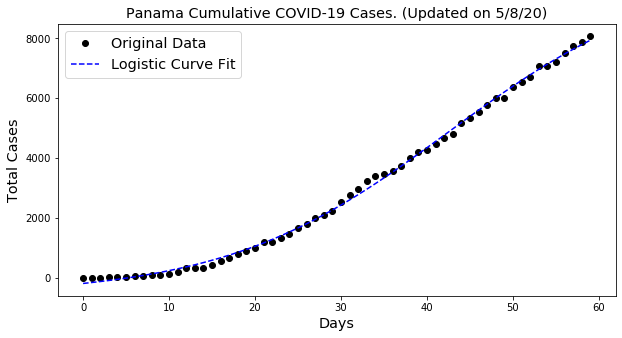



Norway

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 8070
	Confirmed cases on 5/1/20 	 7783
	Ratio: 1.04
	Weekly increase: 3.7 %
	Daily increase: 0.5 % per day
	Doubling Time (represents recent growth): 134.0 days

** Based on Logistic Fit**

	R^2: 0.9979821016258691
	Doubling Time (during middle of growth):  12.27 (± 0.62 ) days


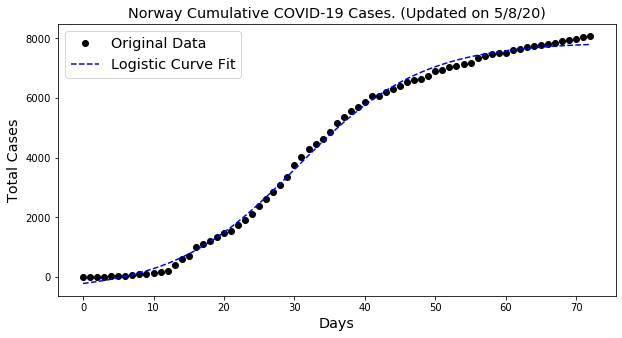



Kuwait

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 7208
	Confirmed cases on 5/1/20 	 4377
	Ratio: 1.65
	Weekly increase: 64.7 %
	Daily increase: 7.4 % per day
	Doubling Time (represents recent growth): 9.7 days

** Based on Logistic Fit**

	R^2: 0.9986427619800399
	Doubling Time (during middle of growth):  18.89 (± 1.26 ) days

** Based on Exponential Fit **

	R^2: 0.9986117037437242
	Doubling Time (represents overall growth):  9.84 (± 0.2 ) days


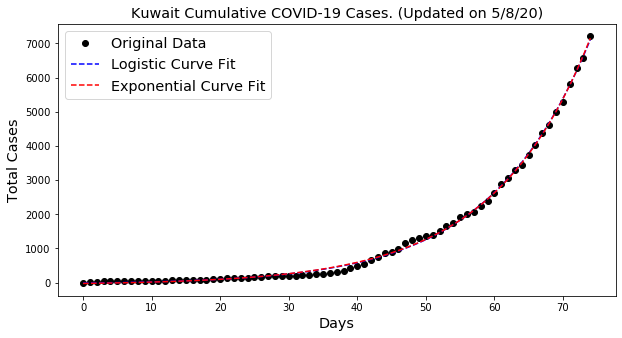



Australia

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 6918
	Confirmed cases on 5/1/20 	 6778
	Ratio: 1.02
	Weekly increase: 2.1 %
	Daily increase: 0.3 % per day
	Doubling Time (represents recent growth): 237.3 days

** Based on Logistic Fit**

	R^2: 0.9991062709827483
	Doubling Time (during middle of growth):  6.27 (± 0.2 ) days


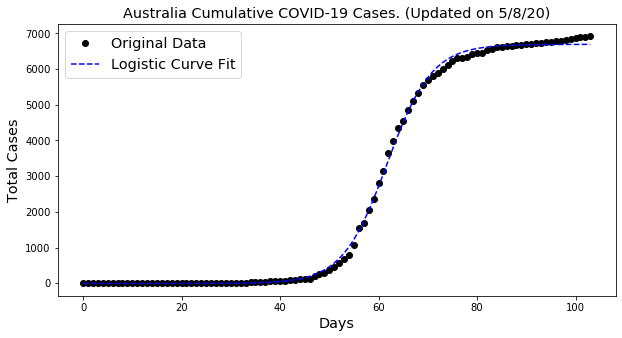



Malaysia

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 6535
	Confirmed cases on 5/1/20 	 6071
	Ratio: 1.08
	Weekly increase: 7.6 %
	Daily increase: 1.1 % per day
	Doubling Time (represents recent growth): 65.9 days

** Based on Logistic Fit**

	R^2: 0.9976298824468607
	Doubling Time (during middle of growth):  12.0 (± 0.52 ) days


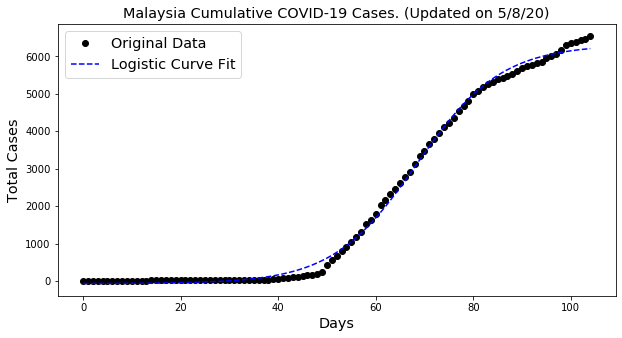



Finland

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 5738
	Confirmed cases on 5/1/20 	 5051
	Ratio: 1.14
	Weekly increase: 13.6 %
	Daily increase: 1.8 % per day
	Doubling Time (represents recent growth): 38.0 days

** Based on Logistic Fit**

	R^2: 0.9981440668120682
	Doubling Time (during middle of growth):  15.11 (± 0.63 ) days

** Based on Exponential Fit **

	R^2: 0.9529310229371035
	Doubling Time (represents overall growth):  16.27 (± 1.85 ) days


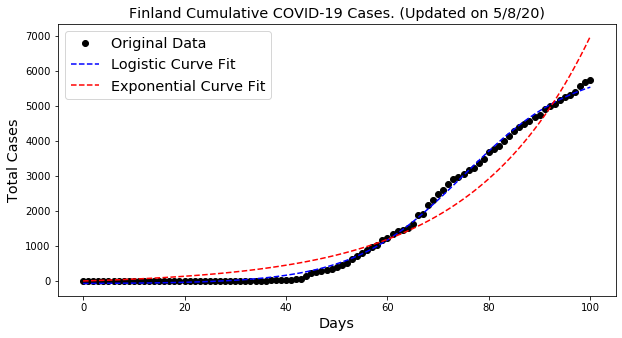



Morocco

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 5711
	Confirmed cases on 5/1/20 	 4569
	Ratio: 1.25
	Weekly increase: 25.0 %
	Daily increase: 3.2 % per day
	Doubling Time (represents recent growth): 21.7 days

** Based on Logistic Fit**

	R^2: 0.9984355439739216
	Doubling Time (during middle of growth):  13.67 (± 0.73 ) days


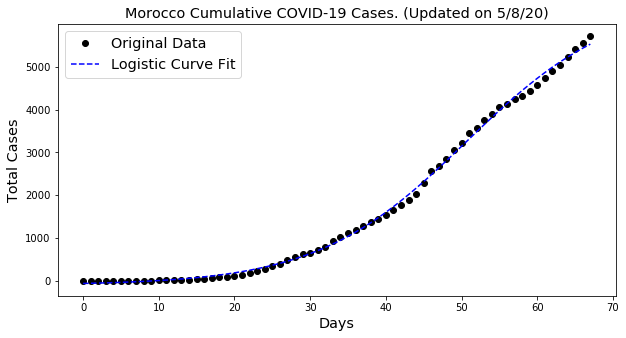



Argentina

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 5611
	Confirmed cases on 5/1/20 	 4532
	Ratio: 1.24
	Weekly increase: 23.8 %
	Daily increase: 3.1 % per day
	Doubling Time (represents recent growth): 22.7 days

** Based on Logistic Fit**

	R^2: 0.9970677104956928
	Doubling Time (during middle of growth):  21.16 (± 2.29 ) days


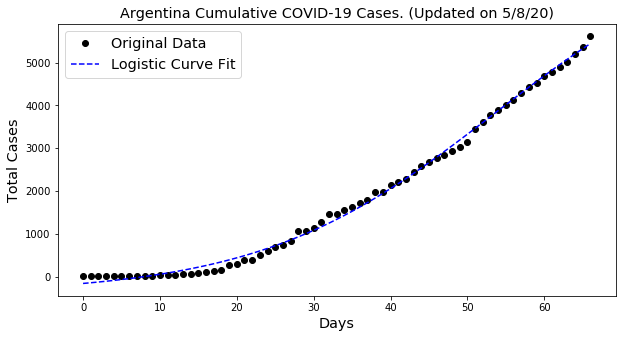



Algeria

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 5369
	Confirmed cases on 5/1/20 	 4154
	Ratio: 1.29
	Weekly increase: 29.2 %
	Daily increase: 3.7 % per day
	Doubling Time (represents recent growth): 18.9 days

** Based on Logistic Fit**

	R^2: 0.9945693325079284
	Doubling Time (during middle of growth):  20.73 (± 2.63 ) days

** Based on Exponential Fit **

	R^2: 0.9619192239030893
	Doubling Time (represents overall growth):  12.34 (± 1.5 ) days


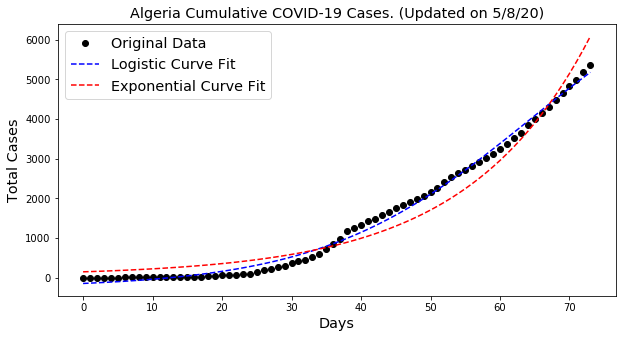



Kazakhstan

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 4834
	Confirmed cases on 5/1/20 	 3597
	Ratio: 1.34
	Weekly increase: 34.4 %
	Daily increase: 4.3 % per day
	Doubling Time (represents recent growth): 16.4 days

** Based on Logistic Fit**

	R^2: 0.9992577745748983
	Doubling Time (during middle of growth):  16.41 (± 0.92 ) days

** Based on Exponential Fit **

	R^2: 0.9745167741112098
	Doubling Time (represents overall growth):  9.74 (± 1.11 ) days


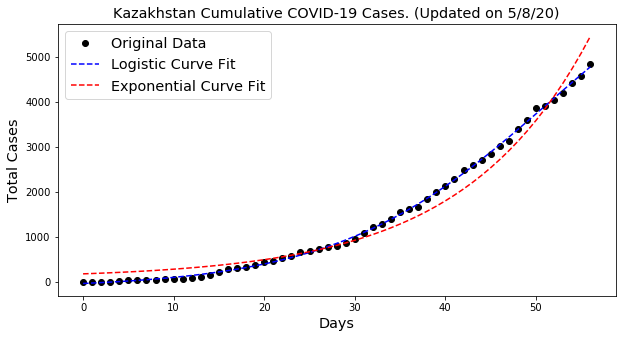



Moldova

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 4728
	Confirmed cases on 5/1/20 	 3980
	Ratio: 1.19
	Weekly increase: 18.8 %
	Daily increase: 2.5 % per day
	Doubling Time (represents recent growth): 28.2 days

** Based on Logistic Fit**

	R^2: 0.9977053827152516
	Doubling Time (during middle of growth):  13.69 (± 0.96 ) days


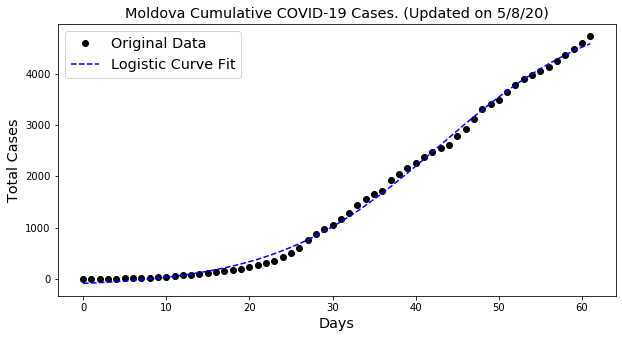



Bahrain

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 4444
	Confirmed cases on 5/1/20 	 3170
	Ratio: 1.4
	Weekly increase: 40.2 %
	Daily increase: 4.9 % per day
	Doubling Time (represents recent growth): 14.4 days

** Based on Logistic Fit**

	R^2: 0.9961286599047929
	Doubling Time (during middle of growth):  20.89 (± 2.31 ) days

** Based on Exponential Fit **

	R^2: 0.9912749747566589
	Doubling Time (represents overall growth):  13.38 (± 0.78 ) days


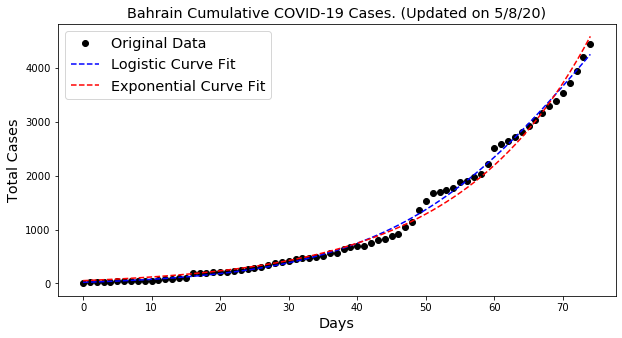



Ghana

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 4012
	Confirmed cases on 5/1/20 	 2074
	Ratio: 1.93
	Weekly increase: 93.4 %
	Daily increase: 9.9 % per day
	Doubling Time (represents recent growth): 7.4 days

** Based on Logistic Fit**

	R^2: 0.9897658641552225
	Doubling Time (during middle of growth):  19.01 (± 0.94 ) days

** Based on Exponential Fit **

	R^2: 0.9897658644274006
	Doubling Time (represents overall growth):  9.51 (± 0.68 ) days


C:\Users\barba\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt


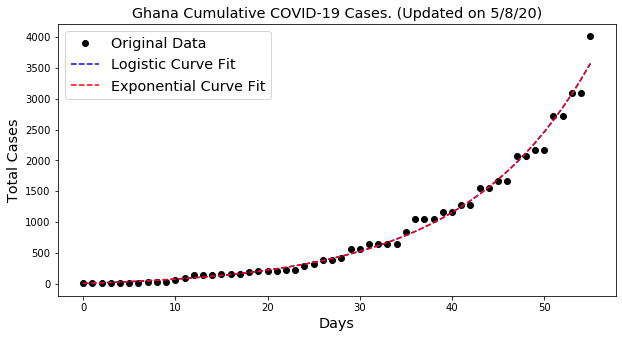



Nigeria

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 3912
	Confirmed cases on 5/1/20 	 2170
	Ratio: 1.8
	Weekly increase: 80.3 %
	Daily increase: 8.8 % per day
	Doubling Time (represents recent growth): 8.2 days

** Based on Logistic Fit**

	R^2: 0.9979020814980992
	Doubling Time (during middle of growth):  13.32 (± 0.96 ) days

** Based on Exponential Fit **

	R^2: 0.9976189817475375
	Doubling Time (represents overall growth):  7.49 (± 0.19 ) days


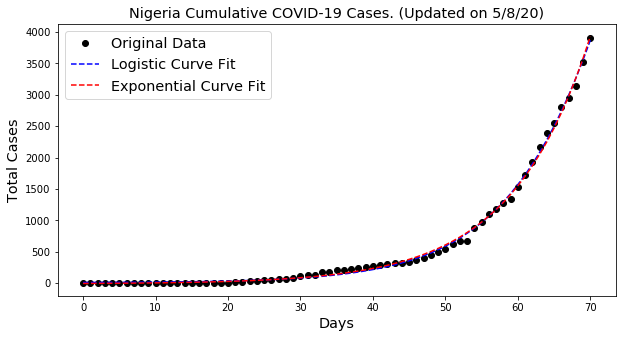



Luxembourg

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 3871
	Confirmed cases on 5/1/20 	 3802
	Ratio: 1.02
	Weekly increase: 1.8 %
	Daily increase: 0.3 % per day
	Doubling Time (represents recent growth): 269.8 days

** Based on Logistic Fit**

	R^2: 0.9962502322338689
	Doubling Time (during middle of growth):  8.57 (± 0.57 ) days


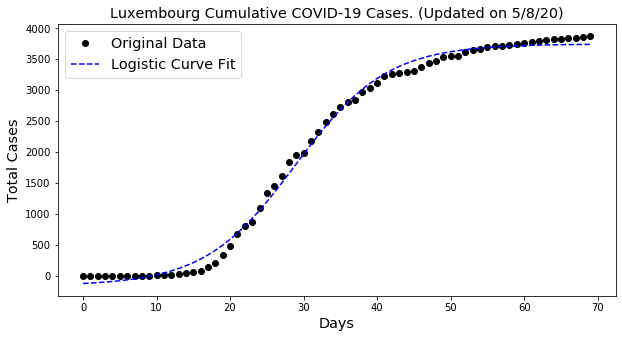



Afghanistan

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 3778
	Confirmed cases on 5/1/20 	 2335
	Ratio: 1.62
	Weekly increase: 61.8 %
	Daily increase: 7.1 % per day
	Doubling Time (represents recent growth): 10.1 days

** Based on Logistic Fit**

	R^2: 0.9984365158277512
	Doubling Time (during middle of growth):  19.68 (± 1.06 ) days

** Based on Exponential Fit **

	R^2: 0.9984365159044417
	Doubling Time (represents overall growth):  9.84 (± 0.21 ) days


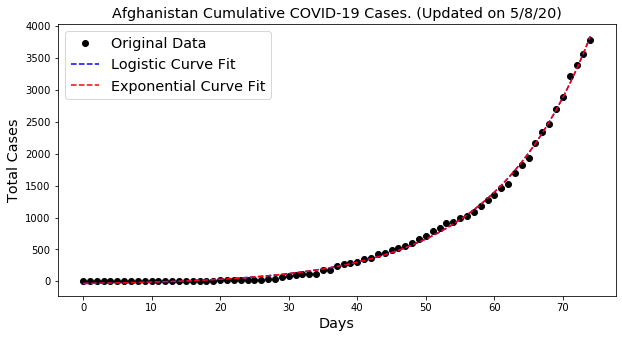



Hungary

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 3178
	Confirmed cases on 5/1/20 	 2863
	Ratio: 1.11
	Weekly increase: 11.0 %
	Daily increase: 1.5 % per day
	Doubling Time (represents recent growth): 46.5 days

** Based on Logistic Fit**

	R^2: 0.9989606745405197
	Doubling Time (during middle of growth):  13.34 (± 0.57 ) days


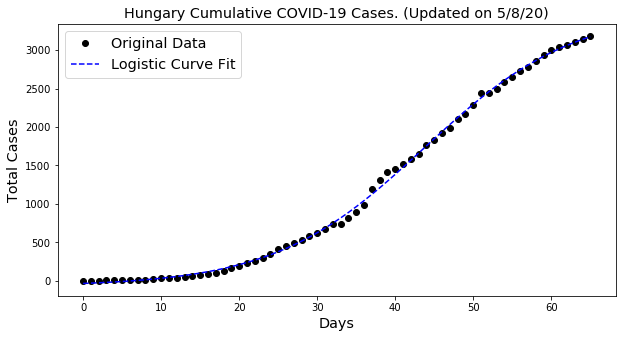



Oman

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 3112
	Confirmed cases on 5/1/20 	 2447
	Ratio: 1.27
	Weekly increase: 27.2 %
	Daily increase: 3.5 % per day
	Doubling Time (represents recent growth): 20.2 days

** Based on Logistic Fit**

	R^2: 0.9987267000547538
	Doubling Time (during middle of growth):  11.35 (± 0.47 ) days

** Based on Exponential Fit **

	R^2: 0.9788011004459065
	Doubling Time (represents overall growth):  12.56 (± 1.13 ) days


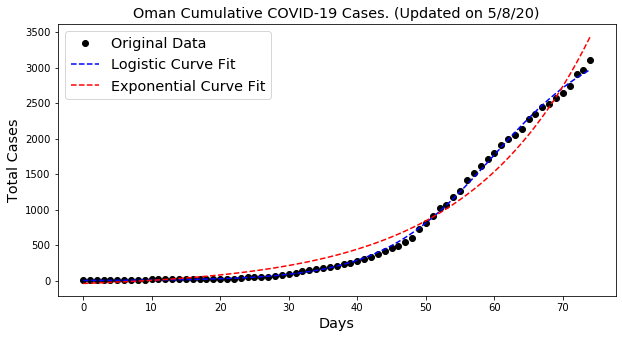



Armenia

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 3029
	Confirmed cases on 5/1/20 	 2148
	Ratio: 1.41
	Weekly increase: 41.0 %
	Daily increase: 5.0 % per day
	Doubling Time (represents recent growth): 14.1 days

** Based on Logistic Fit**

	R^2: 0.9936476006117387
	Doubling Time (during middle of growth):  40.75 (± inf ) days

** Based on Exponential Fit **

	R^2: 0.9786014036945436
	Doubling Time (represents overall growth):  13.64 (± 1.39 ) days


C:\OSGEO4~1\apps\Python37\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


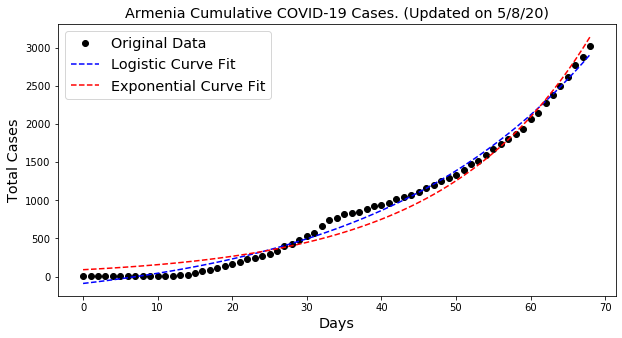



Thailand

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 3000
	Confirmed cases on 5/1/20 	 2960
	Ratio: 1.01
	Weekly increase: 1.4 %
	Daily increase: 0.2 % per day
	Doubling Time (represents recent growth): 361.5 days

** Based on Logistic Fit**

	R^2: 0.9981411923722538
	Doubling Time (during middle of growth):  8.07 (± 0.33 ) days


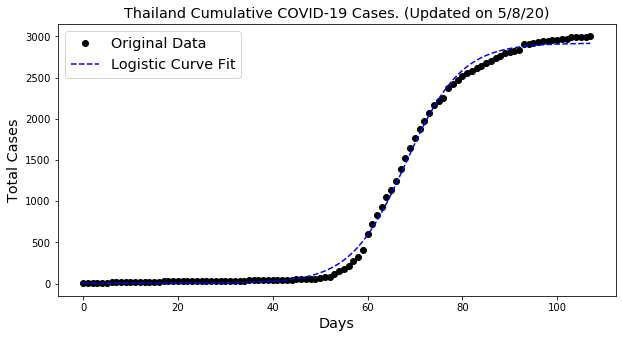



Greece

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 2691
	Confirmed cases on 5/1/20 	 2612
	Ratio: 1.03
	Weekly increase: 3.0 %
	Daily increase: 0.4 % per day
	Doubling Time (represents recent growth): 162.8 days

** Based on Logistic Fit**

	R^2: 0.9978735759176763
	Doubling Time (during middle of growth):  12.29 (± 0.64 ) days


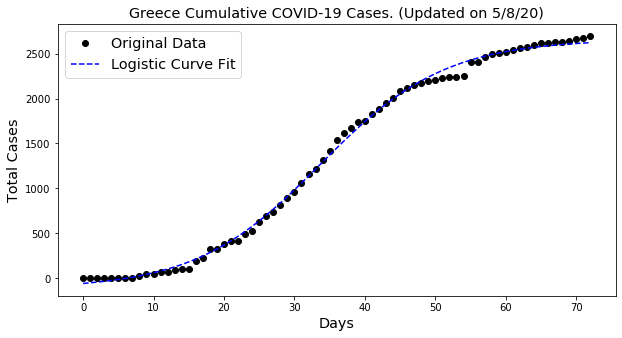



Iraq

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 2603
	Confirmed cases on 5/1/20 	 2153
	Ratio: 1.21
	Weekly increase: 20.9 %
	Daily increase: 2.7 % per day
	Doubling Time (represents recent growth): 25.6 days

** Based on Logistic Fit**

	R^2: 0.9893801921622157
	Doubling Time (during middle of growth):  21.86 (± 3.82 ) days


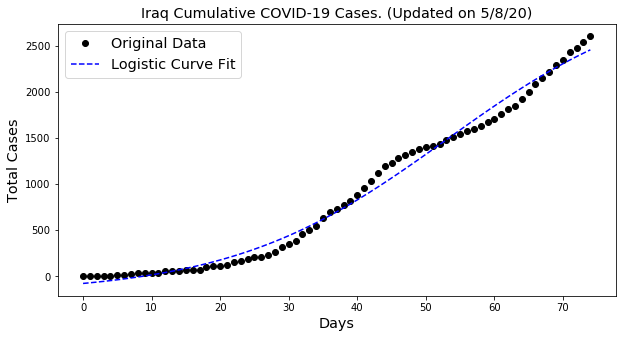



Uzbekistan

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 2325
	Confirmed cases on 5/1/20 	 2086
	Ratio: 1.11
	Weekly increase: 11.5 %
	Daily increase: 1.6 % per day
	Doubling Time (represents recent growth): 44.7 days

** Based on Logistic Fit**

	R^2: 0.9965082238558871
	Doubling Time (during middle of growth):  8.4 (± 0.63 ) days


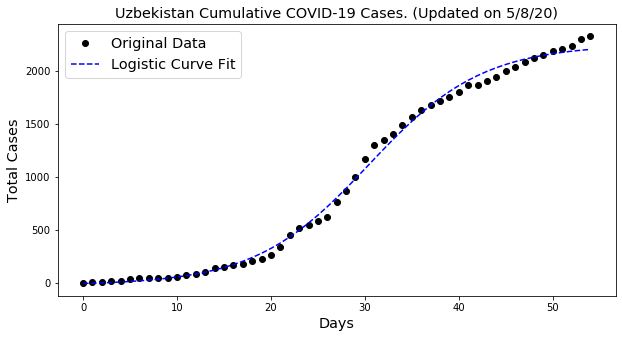



Azerbaijan

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 2279
	Confirmed cases on 5/1/20 	 1854
	Ratio: 1.23
	Weekly increase: 22.9 %
	Daily increase: 3.0 % per day
	Doubling Time (represents recent growth): 23.5 days

** Based on Logistic Fit**

	R^2: 0.9914741146911665
	Doubling Time (during middle of growth):  12.43 (± 1.39 ) days


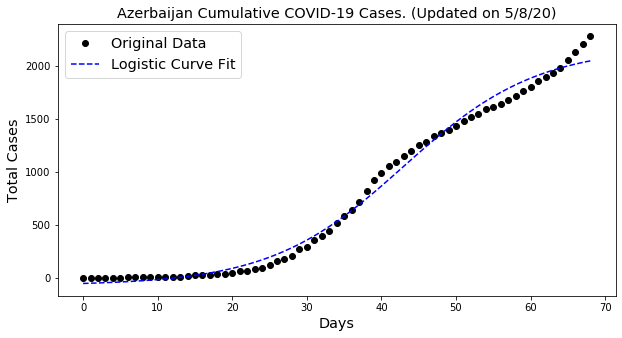



Cameroon

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 2267
	Confirmed cases on 5/1/20 	 1832
	Ratio: 1.24
	Weekly increase: 23.7 %
	Daily increase: 3.1 % per day
	Doubling Time (represents recent growth): 22.8 days

** Based on Logistic Fit**

	R^2: 0.9883567031530277
	Doubling Time (during middle of growth):  19.43 (± 4.15 ) days

** Based on Exponential Fit **

	R^2: 0.9592069001811534
	Doubling Time (represents overall growth):  13.19 (± 2.01 ) days


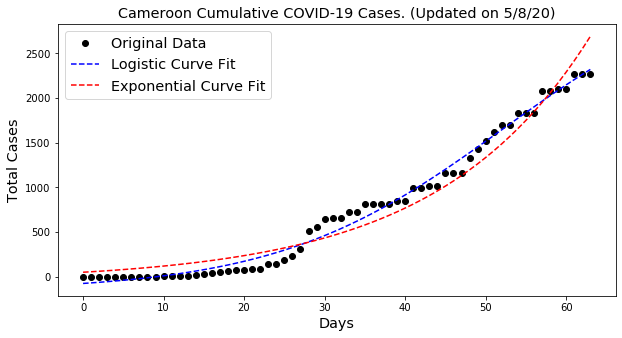



Bolivia

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 2266
	Confirmed cases on 5/1/20 	 1229
	Ratio: 1.84
	Weekly increase: 84.4 %
	Daily increase: 9.1 % per day
	Doubling Time (represents recent growth): 7.9 days

** Based on Logistic Fit**

	R^2: 0.9983622226647343
	Doubling Time (during middle of growth):  18.91 (± 0.86 ) days

** Based on Exponential Fit **

	R^2: 0.9983622227795641
	Doubling Time (represents overall growth):  9.45 (± 0.25 ) days


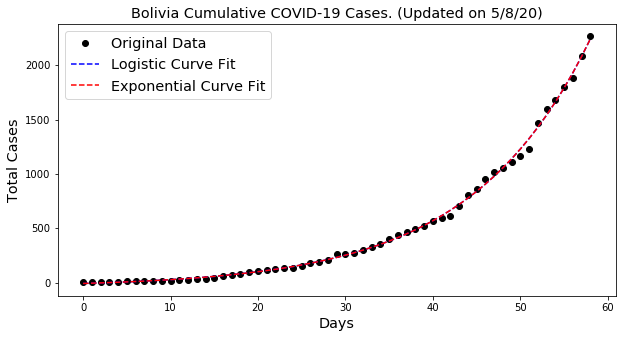



Croatia

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 2161
	Confirmed cases on 5/1/20 	 2085
	Ratio: 1.04
	Weekly increase: 3.6 %
	Daily increase: 0.5 % per day
	Doubling Time (represents recent growth): 135.5 days

** Based on Logistic Fit**

	R^2: 0.9980350771528607
	Doubling Time (during middle of growth):  10.21 (± 0.48 ) days


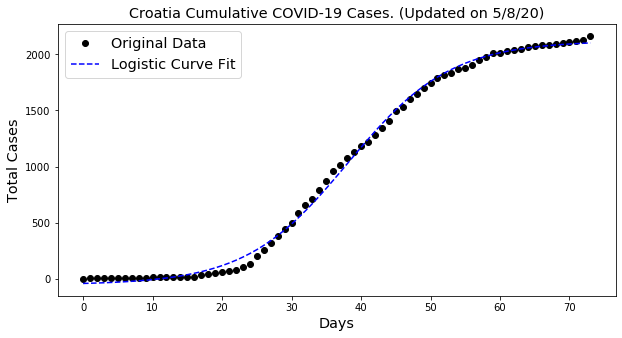



Bosnia and Herzegovina

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 2070
	Confirmed cases on 5/1/20 	 1781
	Ratio: 1.16
	Weekly increase: 16.2 %
	Daily increase: 2.2 % per day
	Doubling Time (represents recent growth): 32.3 days

** Based on Logistic Fit**

	R^2: 0.9951758935921109
	Doubling Time (during middle of growth):  17.96 (± 2.13 ) days


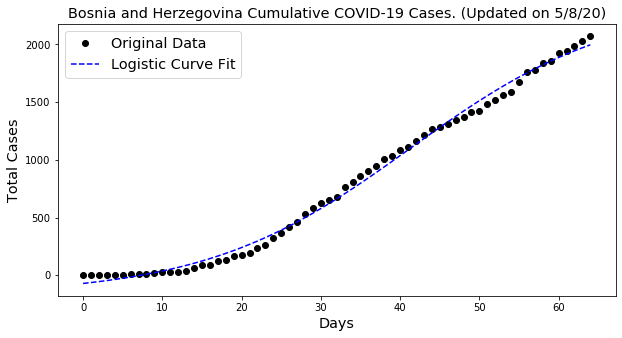



Guinea

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 2009
	Confirmed cases on 5/1/20 	 1537
	Ratio: 1.31
	Weekly increase: 30.7 %
	Daily increase: 3.9 % per day
	Doubling Time (represents recent growth): 18.1 days

** Based on Logistic Fit**

	R^2: 0.9986217126795395
	Doubling Time (during middle of growth):  10.92 (± 0.61 ) days

** Based on Exponential Fit **

	R^2: 0.9855853776048886
	Doubling Time (represents overall growth):  10.79 (± 0.98 ) days


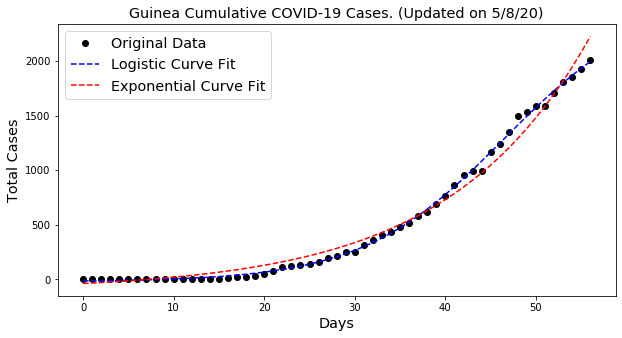



Bulgaria

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 1872
	Confirmed cases on 5/1/20 	 1555
	Ratio: 1.2
	Weekly increase: 20.4 %
	Daily increase: 2.7 % per day
	Doubling Time (represents recent growth): 26.2 days

** Based on Logistic Fit**

	R^2: 0.9963491233350545
	Doubling Time (during middle of growth):  42.89 (± 17.84 ) days

** Based on Exponential Fit **

	R^2: 0.9700572483068607
	Doubling Time (represents overall growth):  13.95 (± 1.95 ) days


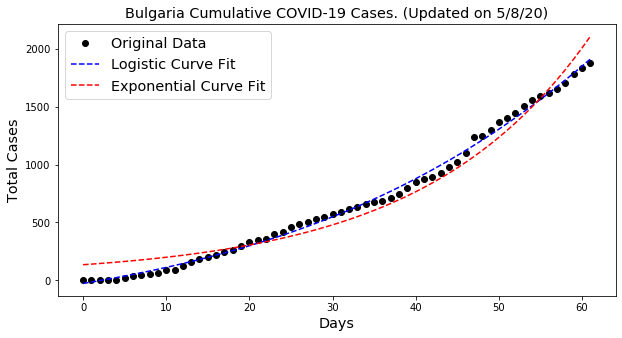



Iceland

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 1801
	Confirmed cases on 5/1/20 	 1798
	Ratio: 1.0
	Weekly increase: 0.2 %
	Daily increase: 0.0 % per day
	Doubling Time (represents recent growth): 2910.4 days

** Based on Logistic Fit**

	R^2: 0.9995216529969098
	Doubling Time (during middle of growth):  7.95 (± 0.19 ) days


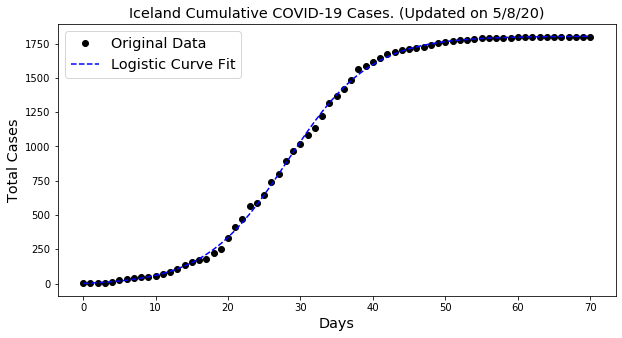



Honduras

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 1771
	Confirmed cases on 5/1/20 	 804
	Ratio: 2.2
	Weekly increase: 120.3 %
	Daily increase: 11.9 % per day
	Doubling Time (represents recent growth): 6.1 days

** Based on Logistic Fit**

	R^2: 0.9630129379722606
	Doubling Time (during middle of growth):  20.05 (± 2.49 ) days

** Based on Exponential Fit **

	R^2: 0.9630129385435695
	Doubling Time (represents overall growth):  10.02 (± 1.34 ) days


C:\Users\barba\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt


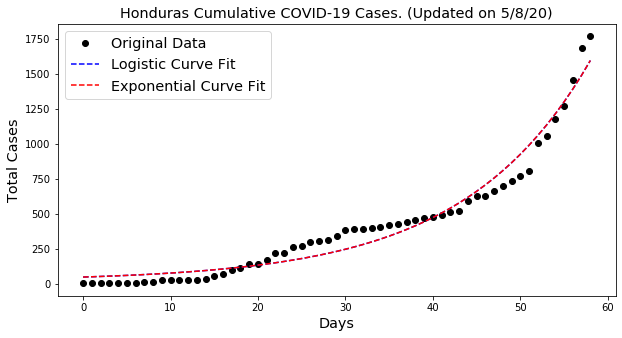



Cuba

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 1741
	Confirmed cases on 5/1/20 	 1537
	Ratio: 1.13
	Weekly increase: 13.3 %
	Daily increase: 1.8 % per day
	Doubling Time (represents recent growth): 38.9 days

** Based on Logistic Fit**

	R^2: 0.9993121987339801
	Doubling Time (during middle of growth):  12.11 (± 0.45 ) days


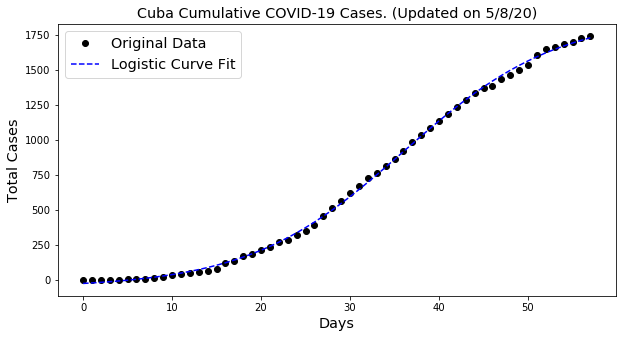



Estonia

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 1725
	Confirmed cases on 5/1/20 	 1694
	Ratio: 1.02
	Weekly increase: 1.8 %
	Daily increase: 0.3 % per day
	Doubling Time (represents recent growth): 267.6 days

** Based on Logistic Fit**

	R^2: 0.99819202473635
	Doubling Time (during middle of growth):  11.8 (± 0.56 ) days


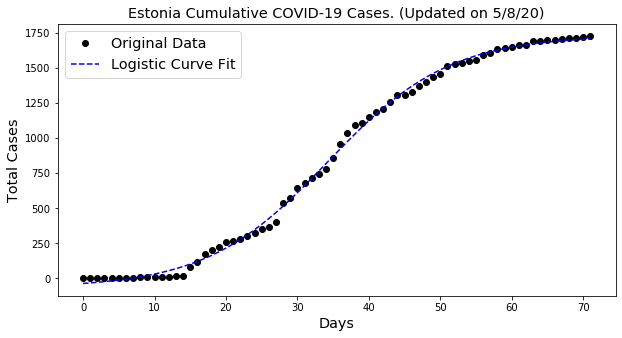



Cote d'Ivoire

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 1602
	Confirmed cases on 5/1/20 	 1333
	Ratio: 1.2
	Weekly increase: 20.2 %
	Daily increase: 2.7 % per day
	Doubling Time (represents recent growth): 26.4 days

** Based on Logistic Fit**

	R^2: 0.9980318876764371
	Doubling Time (during middle of growth):  15.43 (± 1.18 ) days

** Based on Exponential Fit **

	R^2: 0.9603618515111078
	Doubling Time (represents overall growth):  13.63 (± 2.3 ) days


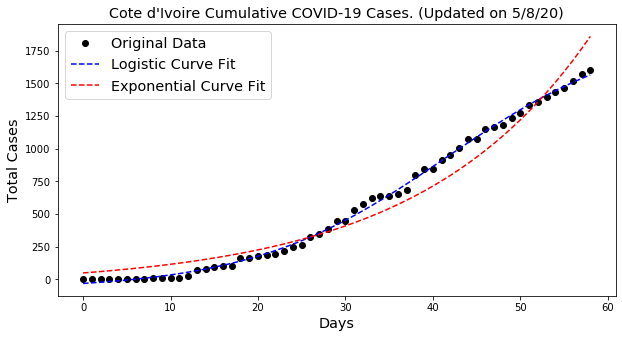



North Macedonia

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 1586
	Confirmed cases on 5/1/20 	 1494
	Ratio: 1.06
	Weekly increase: 6.2 %
	Daily increase: 0.9 % per day
	Doubling Time (represents recent growth): 81.2 days

** Based on Logistic Fit**

	R^2: 0.9989298805232428
	Doubling Time (during middle of growth):  11.44 (± 0.42 ) days


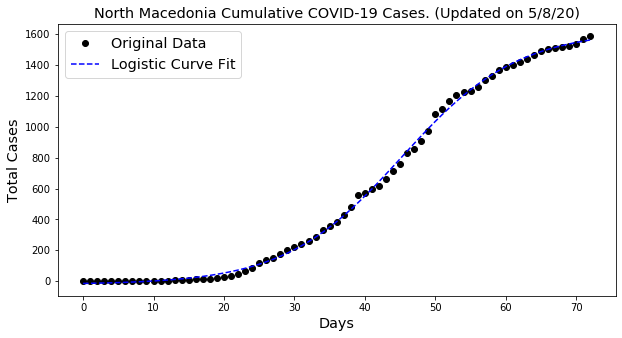



Senegal

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 1551
	Confirmed cases on 5/1/20 	 1024
	Ratio: 1.51
	Weekly increase: 51.5 %
	Daily increase: 6.1 % per day
	Doubling Time (represents recent growth): 11.7 days

** Based on Logistic Fit**

	R^2: 0.9907047349732585
	Doubling Time (during middle of growth):  19.63 (± 3.51 ) days

** Based on Exponential Fit **

	R^2: 0.9907047354398243
	Doubling Time (represents overall growth):  9.81 (± 0.56 ) days


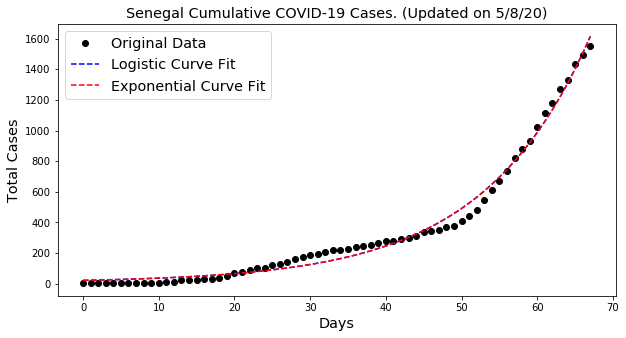



New Zealand

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 1492
	Confirmed cases on 5/1/20 	 1485
	Ratio: 1.0
	Weekly increase: 0.5 %
	Daily increase: 0.1 % per day
	Doubling Time (represents recent growth): 1031.7 days

** Based on Logistic Fit**

	R^2: 0.9990883553245602
	Doubling Time (during middle of growth):  6.19 (± 0.21 ) days


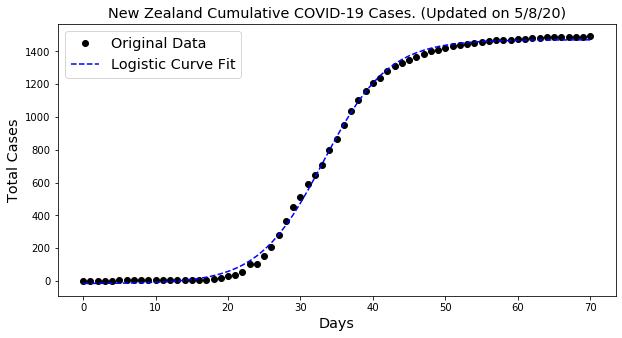



Slovakia

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 1455
	Confirmed cases on 5/1/20 	 1403
	Ratio: 1.04
	Weekly increase: 3.7 %
	Daily increase: 0.5 % per day
	Doubling Time (represents recent growth): 133.3 days

** Based on Logistic Fit**

	R^2: 0.9946846044134696
	Doubling Time (during middle of growth):  12.21 (± 1.14 ) days


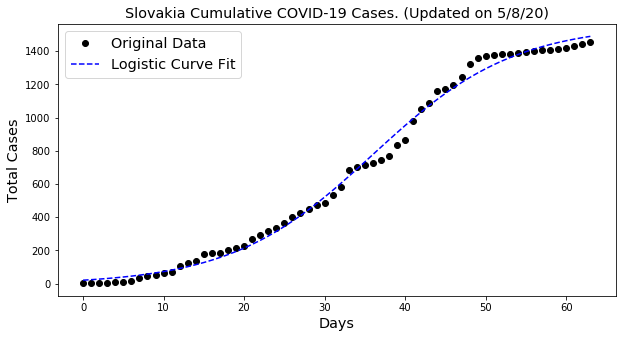



Slovenia

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 1450
	Confirmed cases on 5/1/20 	 1434
	Ratio: 1.01
	Weekly increase: 1.1 %
	Daily increase: 0.2 % per day
	Doubling Time (represents recent growth): 437.3 days

** Based on Logistic Fit**

	R^2: 0.9991735968077275
	Doubling Time (during middle of growth):  13.21 (± 0.51 ) days


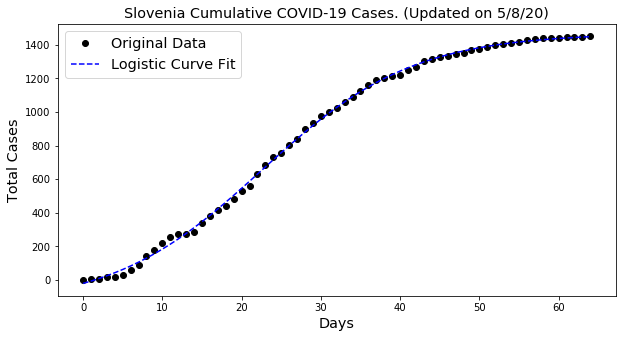



Lithuania

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 1436
	Confirmed cases on 5/1/20 	 1399
	Ratio: 1.03
	Weekly increase: 2.6 %
	Daily increase: 0.4 % per day
	Doubling Time (represents recent growth): 185.9 days

** Based on Logistic Fit**

	R^2: 0.9954778732701494
	Doubling Time (during middle of growth):  10.04 (± 0.74 ) days


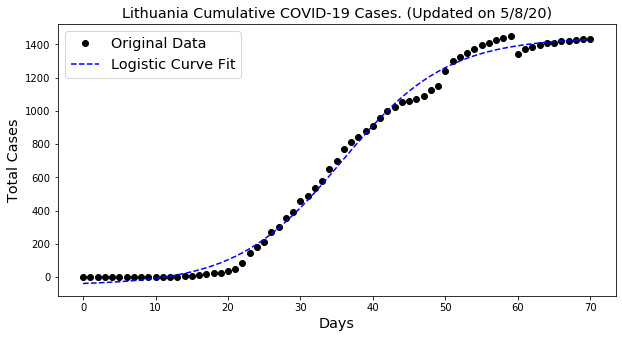



Djibouti

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 1135
	Confirmed cases on 5/1/20 	 1097
	Ratio: 1.03
	Weekly increase: 3.5 %
	Daily increase: 0.5 % per day
	Doubling Time (represents recent growth): 142.5 days

** Based on Logistic Fit**

	R^2: 0.9974200906039397
	Doubling Time (during middle of growth):  4.37 (± 0.3 ) days


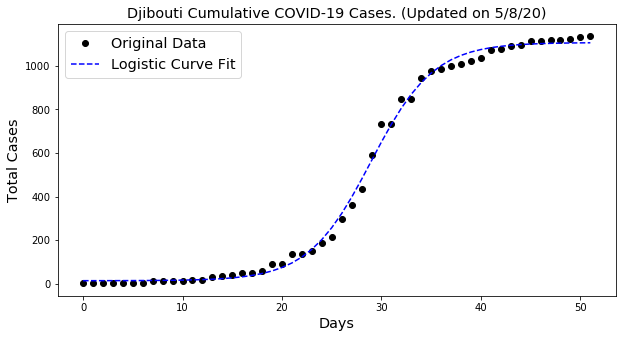



Sudan

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 1111
	Confirmed cases on 5/1/20 	 533
	Ratio: 2.08
	Weekly increase: 108.4 %
	Daily increase: 11.1 % per day
	Doubling Time (represents recent growth): 6.6 days

** Based on Logistic Fit**

	R^2: 0.9969625569192696
	Doubling Time (during middle of growth):  8.53 (± 0.74 ) days

** Based on Exponential Fit **

	R^2: 0.9947625604852633
	Doubling Time (represents overall growth):  5.66 (± 0.24 ) days


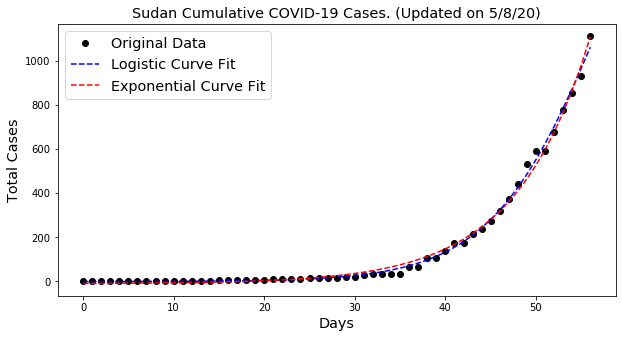



Tunisia

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 1030
	Confirmed cases on 5/1/20 	 998
	Ratio: 1.03
	Weekly increase: 3.2 %
	Daily increase: 0.5 % per day
	Doubling Time (represents recent growth): 153.7 days

** Based on Logistic Fit**

	R^2: 0.9955119536714214
	Doubling Time (during middle of growth):  10.89 (± 0.86 ) days


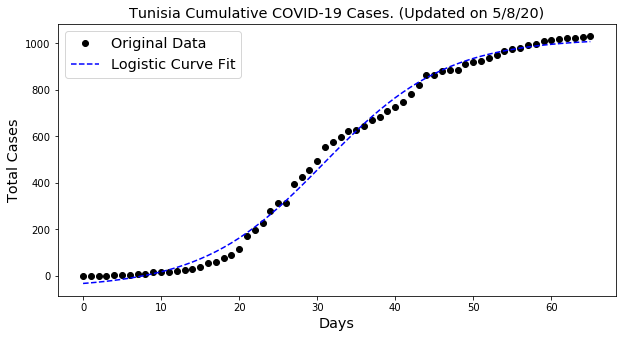



Congo (Kinshasa)

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 937
	Confirmed cases on 5/1/20 	 604
	Ratio: 1.55
	Weekly increase: 55.1 %
	Daily increase: 6.5 % per day
	Doubling Time (represents recent growth): 11.0 days

** Based on Logistic Fit**

	R^2: 0.9925206411000755
	Doubling Time (during middle of growth):  28.69 (± 2.3 ) days

** Based on Exponential Fit **

	R^2: 0.9925206413683448
	Doubling Time (represents overall growth):  14.34 (± 1.05 ) days


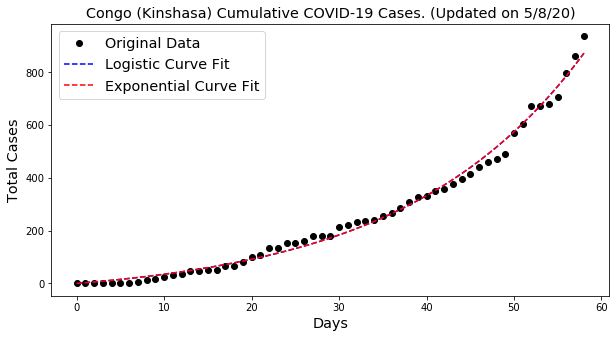



Somalia

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 928
	Confirmed cases on 5/1/20 	 601
	Ratio: 1.54
	Weekly increase: 54.4 %
	Daily increase: 6.4 % per day
	Doubling Time (represents recent growth): 11.2 days

** Based on Logistic Fit**

	R^2: 0.9958828512768377
	Doubling Time (during middle of growth):  8.35 (± 0.76 ) days

** Based on Exponential Fit **

	R^2: 0.9799023864066716
	Doubling Time (represents overall growth):  9.29 (± 0.96 ) days


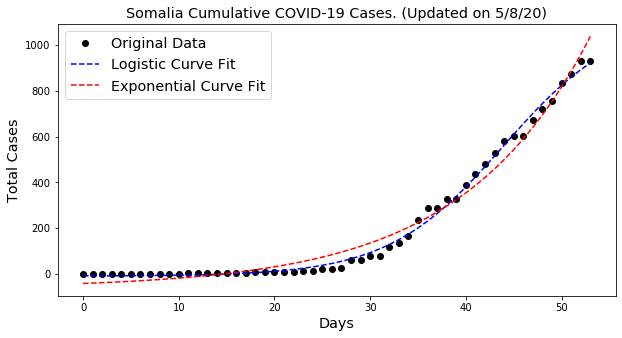



Latvia

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 928
	Confirmed cases on 5/1/20 	 870
	Ratio: 1.07
	Weekly increase: 6.7 %
	Daily increase: 0.9 % per day
	Doubling Time (represents recent growth): 75.2 days

** Based on Logistic Fit**

	R^2: 0.993722558628131
	Doubling Time (during middle of growth):  13.99 (± 1.43 ) days


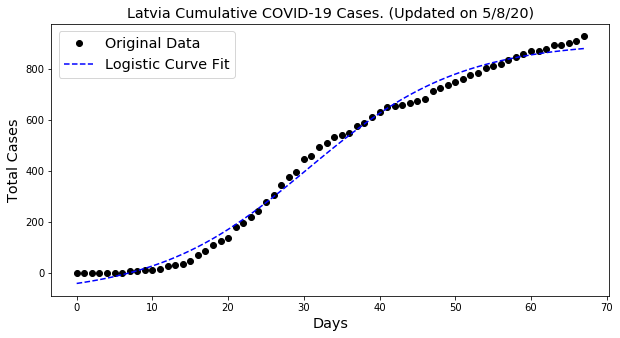



Kyrgyzstan

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 906
	Confirmed cases on 5/1/20 	 756
	Ratio: 1.2
	Weekly increase: 19.8 %
	Daily increase: 2.6 % per day
	Doubling Time (represents recent growth): 26.8 days

** Based on Logistic Fit**

	R^2: 0.996201107465836
	Doubling Time (during middle of growth):  13.63 (± 1.52 ) days


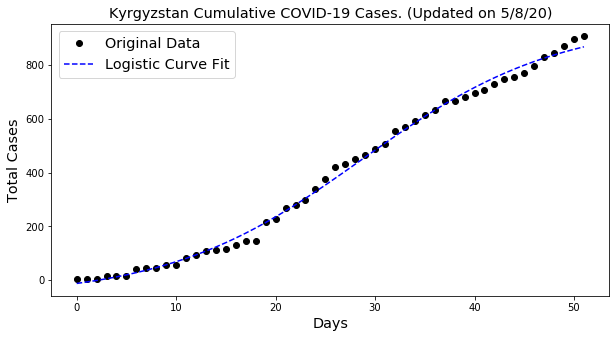



Guatemala

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 900
	Confirmed cases on 5/1/20 	 644
	Ratio: 1.4
	Weekly increase: 39.8 %
	Daily increase: 4.9 % per day
	Doubling Time (represents recent growth): 14.5 days

** Based on Logistic Fit**

	R^2: 0.99782991193553
	Doubling Time (during middle of growth):  12.03 (± 0.91 ) days

** Based on Exponential Fit **

	R^2: 0.9906548811719488
	Doubling Time (represents overall growth):  12.27 (± 0.97 ) days


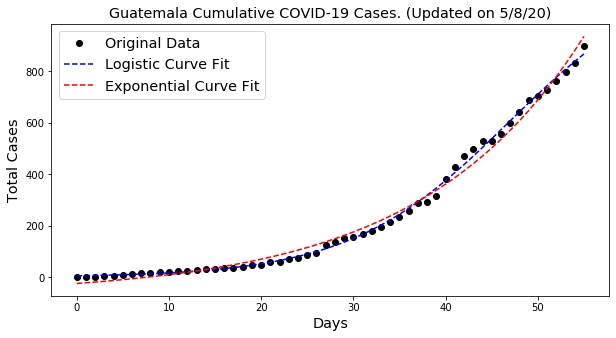



Cyprus

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 891
	Confirmed cases on 5/1/20 	 857
	Ratio: 1.04
	Weekly increase: 4.0 %
	Daily increase: 0.6 % per day
	Doubling Time (represents recent growth): 124.7 days

** Based on Logistic Fit**

	R^2: 0.9986878655722868
	Doubling Time (during middle of growth):  9.76 (± 0.43 ) days


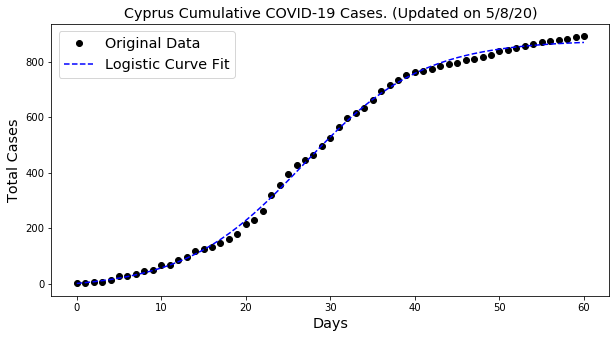



Kosovo

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 861
	Confirmed cases on 5/1/20 	 806
	Ratio: 1.07
	Weekly increase: 6.8 %
	Daily increase: 0.9 % per day
	Doubling Time (represents recent growth): 73.5 days

** Based on Logistic Fit**

	R^2: 0.9980498564891723
	Doubling Time (during middle of growth):  7.22 (± 0.47 ) days


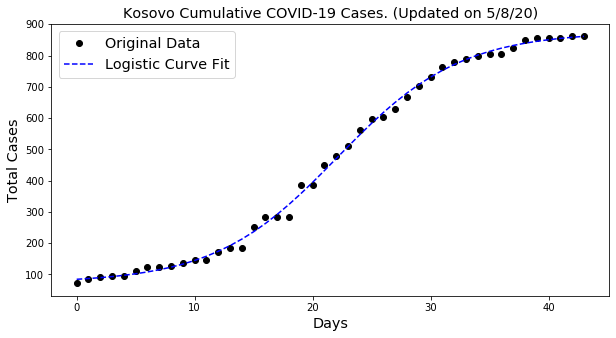



Albania

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 850
	Confirmed cases on 5/1/20 	 782
	Ratio: 1.09
	Weekly increase: 8.7 %
	Daily increase: 1.2 % per day
	Doubling Time (represents recent growth): 58.2 days

** Based on Logistic Fit**

	R^2: 0.9974316508971256
	Doubling Time (during middle of growth):  20.99 (± 2.39 ) days


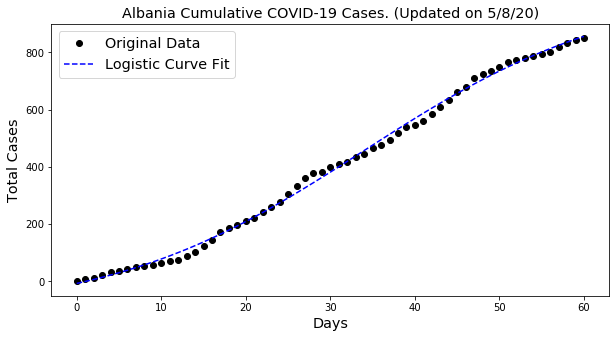



Sri Lanka

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 835
	Confirmed cases on 5/1/20 	 690
	Ratio: 1.21
	Weekly increase: 21.0 %
	Daily increase: 2.8 % per day
	Doubling Time (represents recent growth): 25.4 days

** Based on Logistic Fit**

	R^2: 0.9859673687885088
	Doubling Time (during middle of growth):  21.92 (± 3.47 ) days

** Based on Exponential Fit **

	R^2: 0.9851372278335578
	Doubling Time (represents overall growth):  13.33 (± 0.74 ) days


C:\Users\barba\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
C:\Users\barba\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  


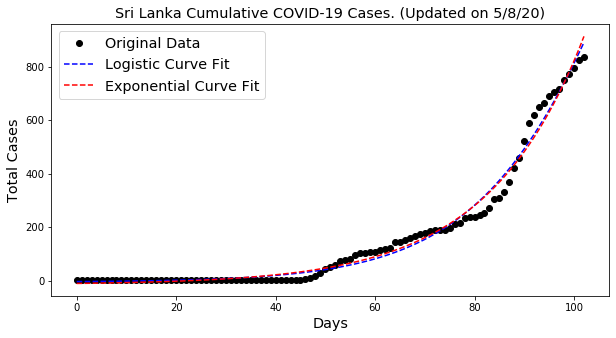



Lebanon

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 796
	Confirmed cases on 5/1/20 	 729
	Ratio: 1.09
	Weekly increase: 9.2 %
	Daily increase: 1.3 % per day
	Doubling Time (represents recent growth): 55.2 days

** Based on Logistic Fit**

	R^2: 0.9952646729486577
	Doubling Time (during middle of growth):  11.37 (± 0.82 ) days


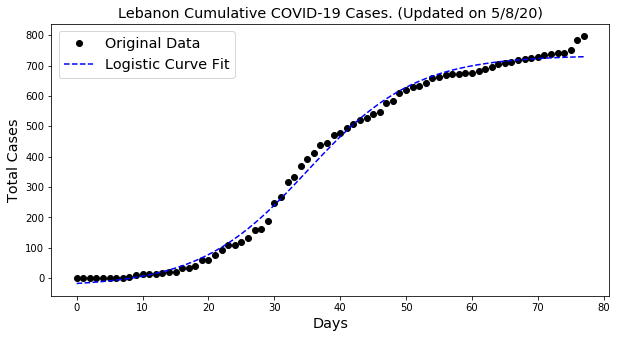



Niger

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 795
	Confirmed cases on 5/1/20 	 728
	Ratio: 1.09
	Weekly increase: 9.2 %
	Daily increase: 1.3 % per day
	Doubling Time (represents recent growth): 55.1 days

** Based on Logistic Fit**

	R^2: 0.9932236875693454
	Doubling Time (during middle of growth):  6.02 (± 0.65 ) days


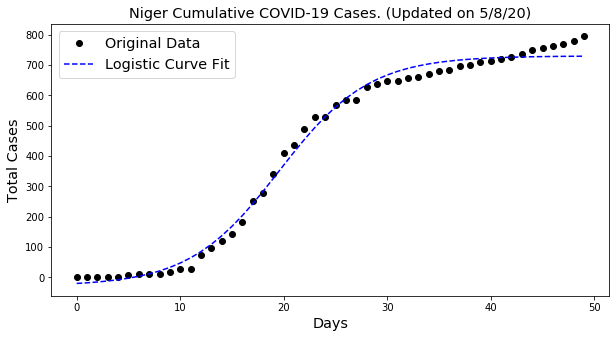



Costa Rica

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 773
	Confirmed cases on 5/1/20 	 725
	Ratio: 1.07
	Weekly increase: 6.6 %
	Daily increase: 0.9 % per day
	Doubling Time (represents recent growth): 75.7 days

** Based on Logistic Fit**

	R^2: 0.9973190210200998
	Doubling Time (during middle of growth):  11.73 (± 0.76 ) days


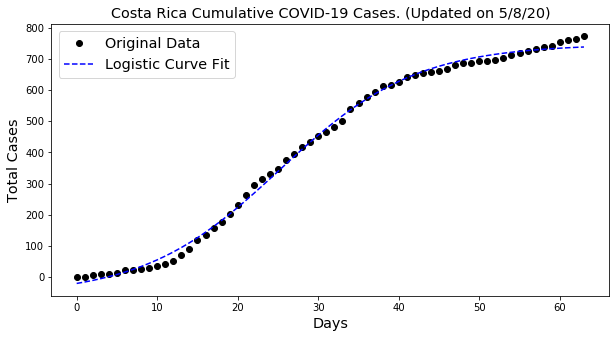



Andorra

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 752
	Confirmed cases on 5/1/20 	 745
	Ratio: 1.01
	Weekly increase: 0.9 %
	Daily increase: 0.1 % per day
	Doubling Time (represents recent growth): 518.8 days

** Based on Logistic Fit**

	R^2: 0.9976791304882764
	Doubling Time (during middle of growth):  9.0 (± 0.48 ) days


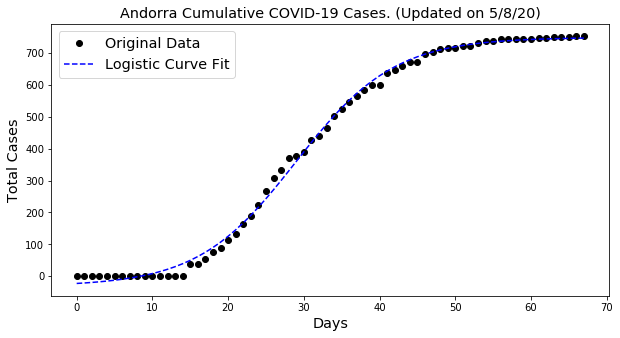



Burkina Faso

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 744
	Confirmed cases on 5/1/20 	 649
	Ratio: 1.15
	Weekly increase: 14.6 %
	Daily increase: 2.0 % per day
	Doubling Time (represents recent growth): 35.5 days

** Based on Logistic Fit**

	R^2: 0.995761073796119
	Doubling Time (during middle of growth):  13.65 (± 1.32 ) days


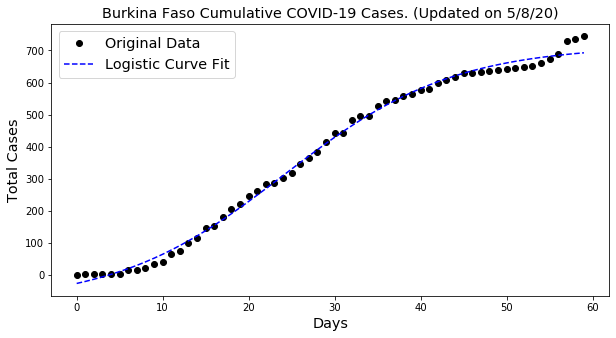



Maldives

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 744
	Confirmed cases on 5/1/20 	 491
	Ratio: 1.52
	Weekly increase: 51.5 %
	Daily increase: 6.1 % per day
	Doubling Time (represents recent growth): 11.7 days

** Based on Logistic Fit**

	R^2: 0.9903675925652902
	Doubling Time (during middle of growth):  5.02 (± 0.62 ) days

** Based on Exponential Fit **

	R^2: 0.9647632049990083
	Doubling Time (represents overall growth):  6.33 (± 0.67 ) days


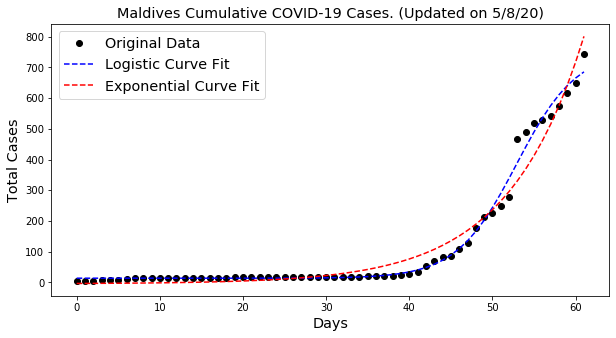



El Salvador

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 742
	Confirmed cases on 5/1/20 	 424
	Ratio: 1.75
	Weekly increase: 75.0 %
	Daily increase: 8.3 % per day
	Doubling Time (represents recent growth): 8.7 days

** Based on Logistic Fit**

	R^2: 0.9955973716568681
	Doubling Time (during middle of growth):  21.26 (± 1.17 ) days

** Based on Exponential Fit **

	R^2: 0.9955973717488303
	Doubling Time (represents overall growth):  10.63 (± 0.58 ) days


C:\Users\barba\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt


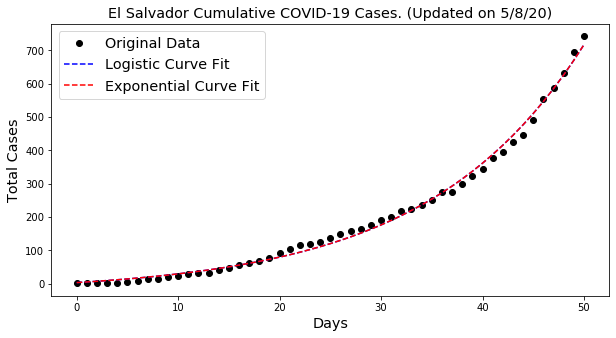



Diamond Princess

** Based on Logistic Fit**

	R^2: 0.9965137933686273
	Doubling Time (during middle of growth):  2.85 (± 0.18 ) days


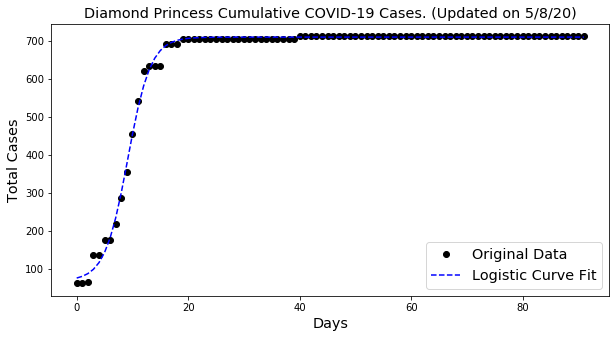



Uruguay

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 694
	Confirmed cases on 5/1/20 	 648
	Ratio: 1.07
	Weekly increase: 7.1 %
	Daily increase: 1.0 % per day
	Doubling Time (represents recent growth): 70.7 days

** Based on Logistic Fit**

	R^2: 0.9935750660564483
	Doubling Time (during middle of growth):  49.04 (± 34.66 ) days


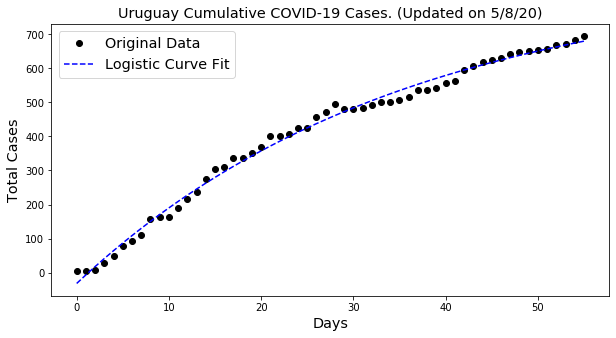



Mali

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 668
	Confirmed cases on 5/1/20 	 508
	Ratio: 1.31
	Weekly increase: 31.5 %
	Daily increase: 4.0 % per day
	Doubling Time (represents recent growth): 17.7 days

** Based on Logistic Fit**

	R^2: 0.9990864675793394
	Doubling Time (during middle of growth):  11.5 (± 0.69 ) days

** Based on Exponential Fit **

	R^2: 0.9897399399248828
	Doubling Time (represents overall growth):  14.0 (± 1.69 ) days


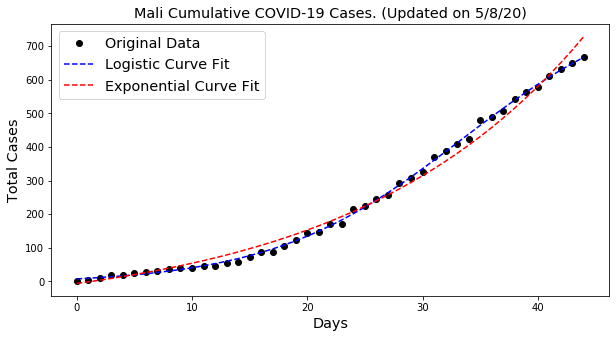



Georgia

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 623
	Confirmed cases on 5/1/20 	 566
	Ratio: 1.1
	Weekly increase: 10.1 %
	Daily increase: 1.4 % per day
	Doubling Time (represents recent growth): 50.6 days

** Based on Logistic Fit**

	R^2: 0.9985410495533488
	Doubling Time (during middle of growth):  15.82 (± 0.81 ) days

** Based on Exponential Fit **

	R^2: 0.983520700582056
	Doubling Time (represents overall growth):  21.79 (± 2.51 ) days


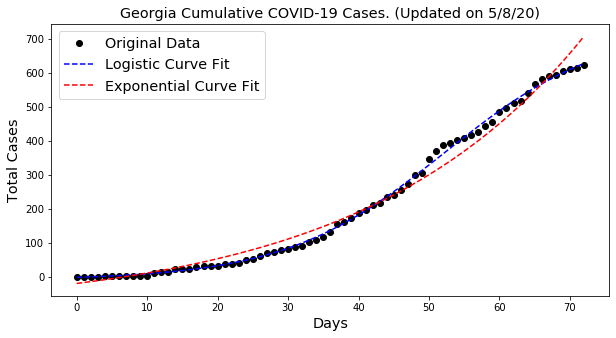



San Marino

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 623
	Confirmed cases on 5/1/20 	 580
	Ratio: 1.07
	Weekly increase: 7.4 %
	Daily increase: 1.0 % per day
	Doubling Time (represents recent growth): 67.8 days

** Based on Logistic Fit**

	R^2: 0.9943415604055146
	Doubling Time (during middle of growth):  32.09 (± 7.16 ) days

** Based on Exponential Fit **

	R^2: 0.9555318672933376
	Doubling Time (represents overall growth):  24.02 (± 5.13 ) days


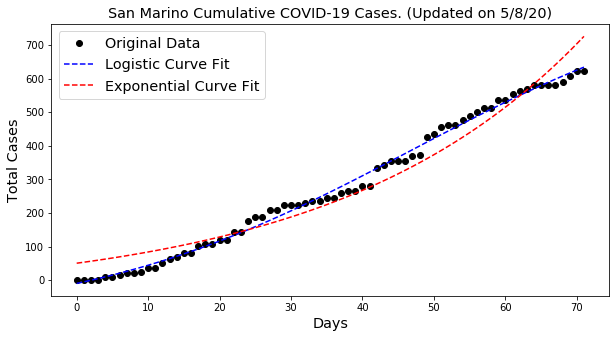



Kenya

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 621
	Confirmed cases on 5/1/20 	 411
	Ratio: 1.51
	Weekly increase: 51.1 %
	Daily increase: 6.1 % per day
	Doubling Time (represents recent growth): 11.8 days

** Based on Logistic Fit**

	R^2: 0.987941226163883
	Doubling Time (during middle of growth):  46.79 (± nan ) days

** Based on Exponential Fit **

	R^2: 0.986416128652275
	Doubling Time (represents overall growth):  19.62 (± 2.61 ) days


C:\Users\barba\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt


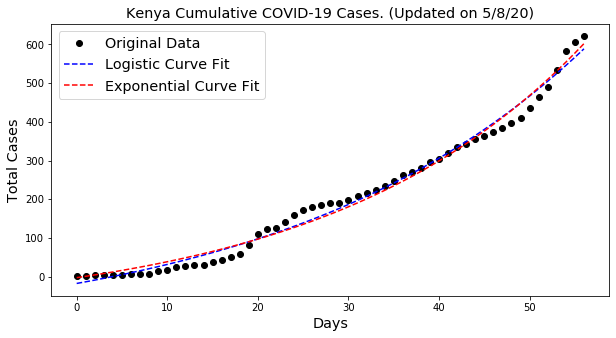



Gabon

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 620
	Confirmed cases on 5/1/20 	 276
	Ratio: 2.25
	Weekly increase: 124.6 %
	Daily increase: 12.3 % per day
	Doubling Time (represents recent growth): 6.0 days

** Based on Logistic Fit**

	R^2: 0.9863538735441226
	Doubling Time (during middle of growth):  16.64 (± 2.38 ) days

** Based on Exponential Fit **

	R^2: 0.9863538740404756
	Doubling Time (represents overall growth):  8.32 (± 0.64 ) days


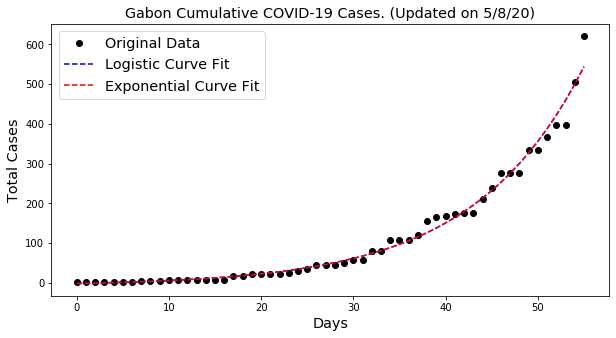



Guinea-Bissau

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 594
	Confirmed cases on 5/1/20 	 257
	Ratio: 2.31
	Weekly increase: 131.1 %
	Daily increase: 12.7 % per day
	Doubling Time (represents recent growth): 5.8 days

** Based on Exponential Fit **

	R^2: 0.9737147328737862
	Doubling Time (represents overall growth):  4.31 (± 0.46 ) days


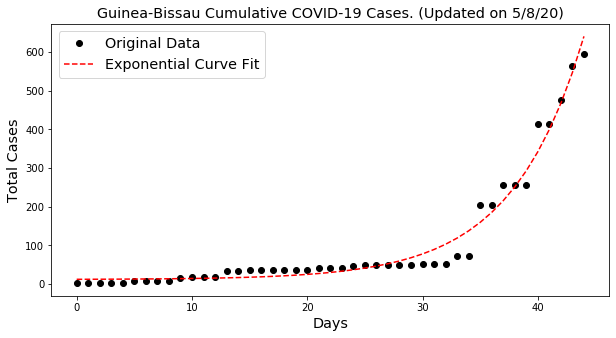



Paraguay

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 563
	Confirmed cases on 5/1/20 	 333
	Ratio: 1.69
	Weekly increase: 69.1 %
	Daily increase: 7.8 % per day
	Doubling Time (represents recent growth): 9.2 days

** Based on Logistic Fit**

	R^2: 0.9718435171767079
	Doubling Time (during middle of growth):  29.7 (± 4.27 ) days

** Based on Exponential Fit **

	R^2: 0.9718435175637884
	Doubling Time (represents overall growth):  14.85 (± 2.06 ) days


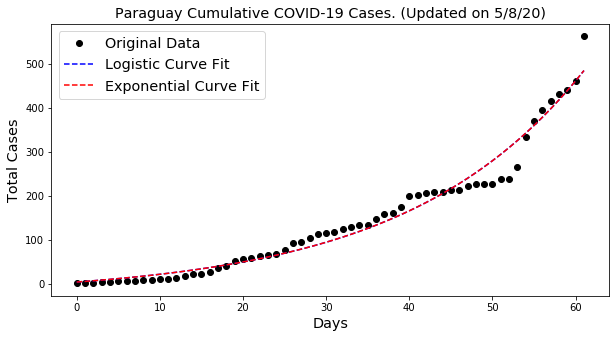



Tajikistan

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 522
	Confirmed cases on 5/1/20 	 15
	Ratio: 34.8
	Weekly increase: 3380.0 %
	Daily increase: 66.0 % per day
	Doubling Time (represents recent growth): 1.4 days

** Based on Logistic Fit**

	R^2: 0.9969500523956877
	Doubling Time (during middle of growth):  2.66 (± 0.97 ) days

** Based on Exponential Fit **

	R^2: 0.9619658996975191
	Doubling Time (represents overall growth):  2.99 (± 2.05 ) days


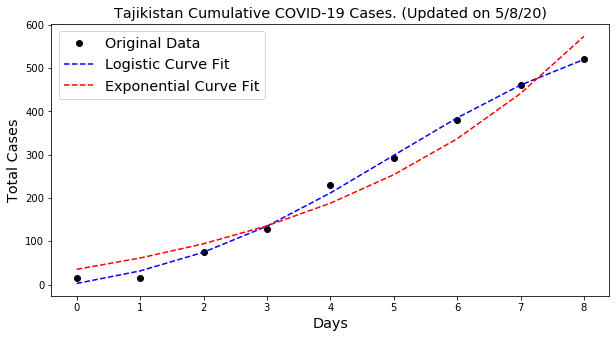



Tanzania

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 509
	Confirmed cases on 5/1/20 	 480
	Ratio: 1.06
	Weekly increase: 6.0 %
	Daily increase: 0.8 % per day
	Doubling Time (represents recent growth): 82.7 days

** Based on Logistic Fit**

	R^2: 0.9795656496859988
	Doubling Time (during middle of growth):  6.73 (± 1.25 ) days


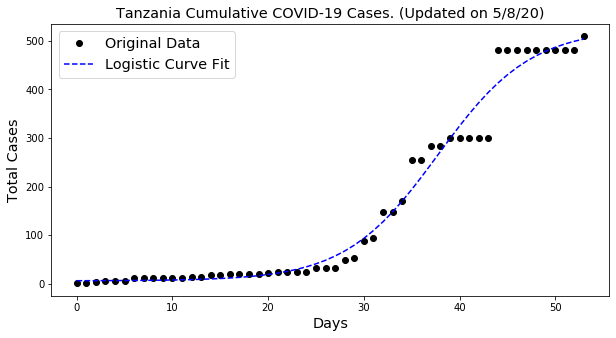



Jordan

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 508
	Confirmed cases on 5/1/20 	 459
	Ratio: 1.11
	Weekly increase: 10.7 %
	Daily increase: 1.5 % per day
	Doubling Time (represents recent growth): 47.8 days

** Based on Logistic Fit**

	R^2: 0.9909955785767391
	Doubling Time (during middle of growth):  10.51 (± 1.17 ) days


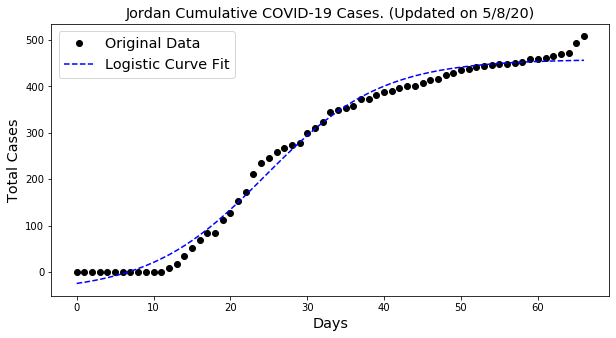



Jamaica

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 490
	Confirmed cases on 5/1/20 	 432
	Ratio: 1.13
	Weekly increase: 13.4 %
	Daily increase: 1.8 % per day
	Doubling Time (represents recent growth): 38.5 days

** Based on Logistic Fit**

	R^2: 0.9954980418802508
	Doubling Time (during middle of growth):  8.0 (± 0.68 ) days

** Based on Exponential Fit **

	R^2: 0.9672413314843936
	Doubling Time (represents overall growth):  13.76 (± 2.08 ) days


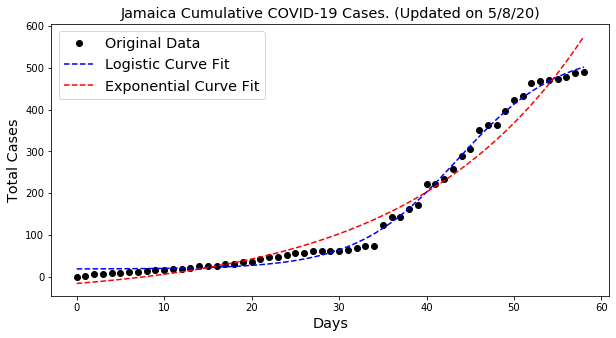



Malta

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 489
	Confirmed cases on 5/1/20 	 467
	Ratio: 1.05
	Weekly increase: 4.7 %
	Daily increase: 0.7 % per day
	Doubling Time (represents recent growth): 105.4 days

** Based on Logistic Fit**

	R^2: 0.994711547179322
	Doubling Time (during middle of growth):  11.06 (± 0.99 ) days


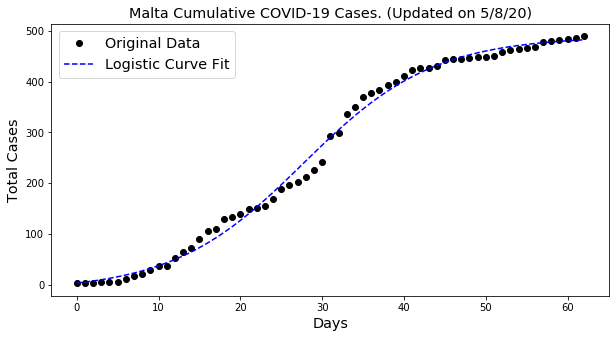



Taiwan*

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 440
	Confirmed cases on 5/1/20 	 429
	Ratio: 1.03
	Weekly increase: 2.6 %
	Daily increase: 0.4 % per day
	Doubling Time (represents recent growth): 191.6 days

** Based on Logistic Fit**

	R^2: 0.9960881378056811
	Doubling Time (during middle of growth):  8.33 (± 0.49 ) days


C:\Users\barba\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
C:\Users\barba\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  


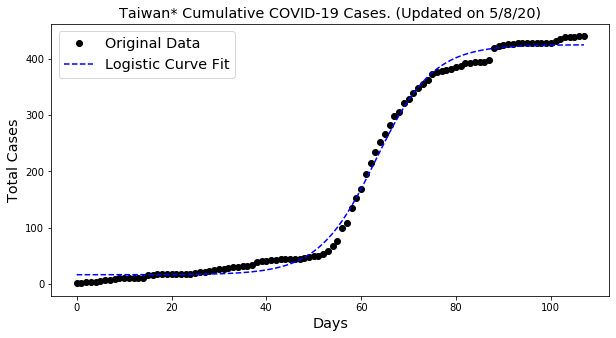



Equatorial Guinea

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 439
	Confirmed cases on 5/1/20 	 315
	Ratio: 1.39
	Weekly increase: 39.4 %
	Daily increase: 4.9 % per day
	Doubling Time (represents recent growth): 14.6 days

** Based on Logistic Fit**

	R^2: 0.9668549423529623
	Doubling Time (during middle of growth):  5.74 (± 1.36 ) days


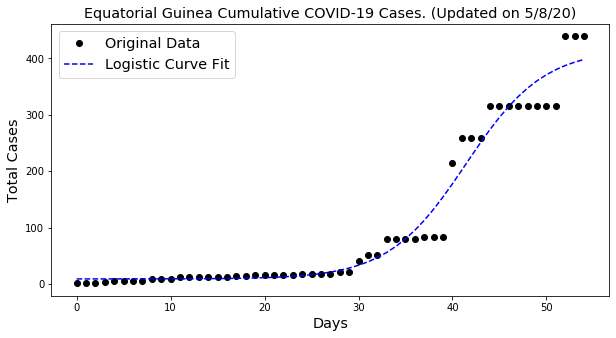



Venezuela

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 388
	Confirmed cases on 5/1/20 	 335
	Ratio: 1.16
	Weekly increase: 15.8 %
	Daily increase: 2.1 % per day
	Doubling Time (represents recent growth): 33.0 days

** Based on Logistic Fit**

	R^2: 0.9822052784864725
	Doubling Time (during middle of growth):  281.35 (± 10299.19 ) days

** Based on Exponential Fit **

	R^2: 0.9558200462736933
	Doubling Time (represents overall growth):  24.51 (± 7.47 ) days


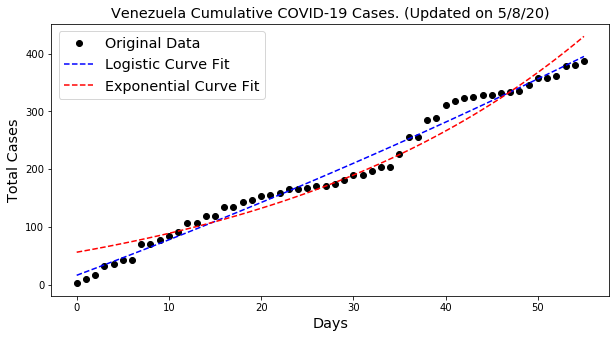



West Bank and Gaza

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 375
	Confirmed cases on 5/1/20 	 353
	Ratio: 1.06
	Weekly increase: 6.2 %
	Daily increase: 0.9 % per day
	Doubling Time (represents recent growth): 80.3 days

** Based on Logistic Fit**

	R^2: 0.9910269097616051
	Doubling Time (during middle of growth):  9.09 (± 0.99 ) days


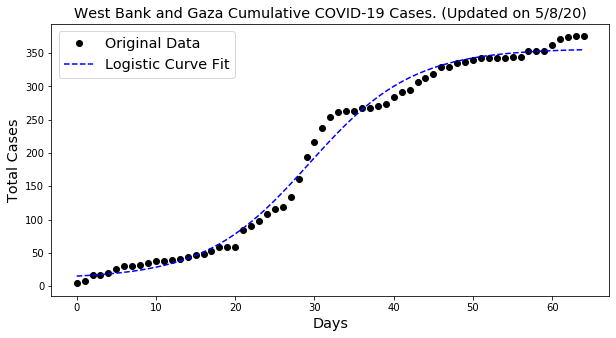



Mauritius

** Based on Logistic Fit**

	R^2: 0.9944556885416221
	Doubling Time (during middle of growth):  5.97 (± 0.58 ) days


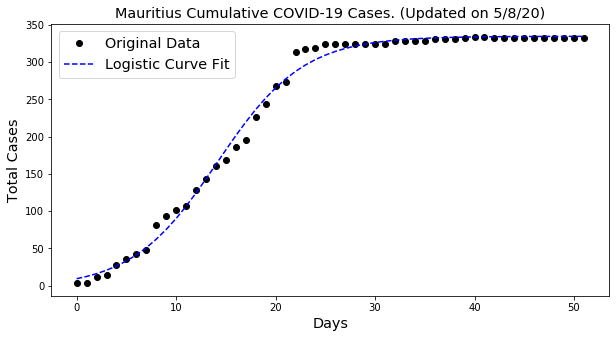



Montenegro

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 324
	Confirmed cases on 5/1/20 	 322
	Ratio: 1.01
	Weekly increase: 0.6 %
	Daily increase: 0.1 % per day
	Doubling Time (represents recent growth): 783.6 days

** Based on Logistic Fit**

	R^2: 0.9961172784226083
	Doubling Time (during middle of growth):  7.43 (± 0.61 ) days


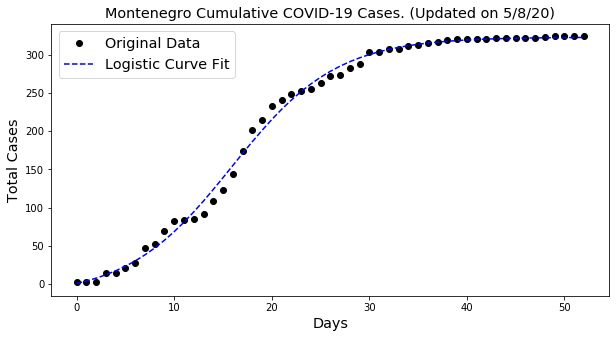



Vietnam

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 288
	Confirmed cases on 5/1/20 	 270
	Ratio: 1.07
	Weekly increase: 6.7 %
	Daily increase: 0.9 % per day
	Doubling Time (represents recent growth): 75.2 days

** Based on Logistic Fit**

	R^2: 0.9983889884012713
	Doubling Time (during middle of growth):  8.09 (± 0.31 ) days


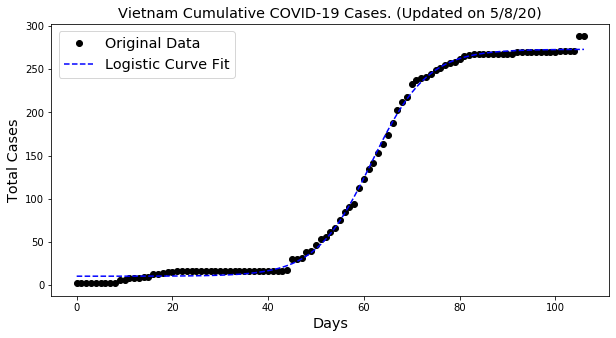



Congo (Brazzaville)

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 274
	Confirmed cases on 5/1/20 	 229
	Ratio: 1.2
	Weekly increase: 19.7 %
	Daily increase: 2.6 % per day
	Doubling Time (represents recent growth): 27.0 days

** Based on Logistic Fit**

	R^2: 0.9884155827455829
	Doubling Time (during middle of growth):  9.16 (± 1.31 ) days

** Based on Exponential Fit **

	R^2: 0.9610314650710193
	Doubling Time (represents overall growth):  23.76 (± 6.7 ) days


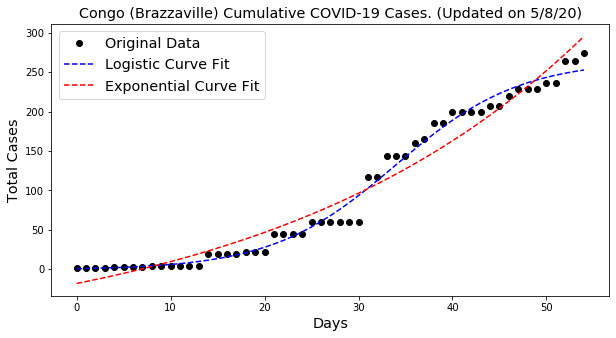



Rwanda

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 273
	Confirmed cases on 5/1/20 	 249
	Ratio: 1.1
	Weekly increase: 9.6 %
	Daily increase: 1.3 % per day
	Doubling Time (represents recent growth): 52.7 days

** Based on Logistic Fit**

	R^2: 0.9840911585805912
	Doubling Time (during middle of growth):  100.88 (± 120.62 ) days

** Based on Exponential Fit **

	R^2: 0.9791881260144417
	Doubling Time (represents overall growth):  28.67 (± 6.76 ) days


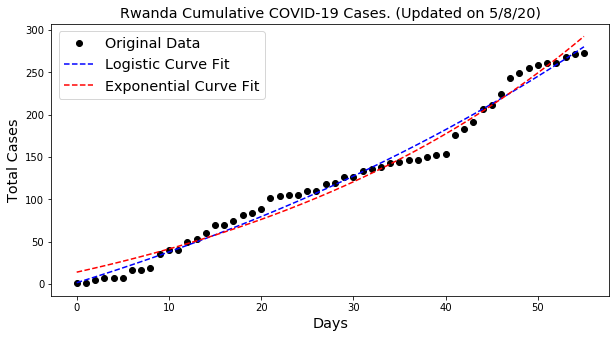



Chad

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 260
	Confirmed cases on 5/1/20 	 73
	Ratio: 3.56
	Weekly increase: 256.2 %
	Daily increase: 19.9 % per day
	Doubling Time (represents recent growth): 3.8 days

** Based on Exponential Fit **

	R^2: 0.9752058155702421
	Doubling Time (represents overall growth):  4.2 (± 0.4 ) days


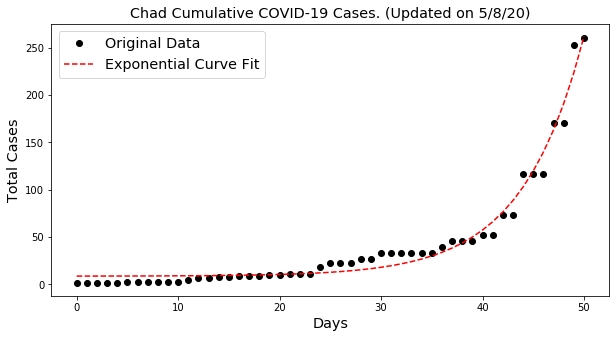



Sierra Leone

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 257
	Confirmed cases on 5/1/20 	 136
	Ratio: 1.89
	Weekly increase: 89.0 %
	Daily increase: 9.5 % per day
	Doubling Time (represents recent growth): 7.6 days

** Based on Logistic Fit**

	R^2: 0.9951338262047545
	Doubling Time (during middle of growth):  12.18 (± 2.45 ) days

** Based on Exponential Fit **

	R^2: 0.9942173369066301
	Doubling Time (represents overall growth):  8.15 (± 0.59 ) days


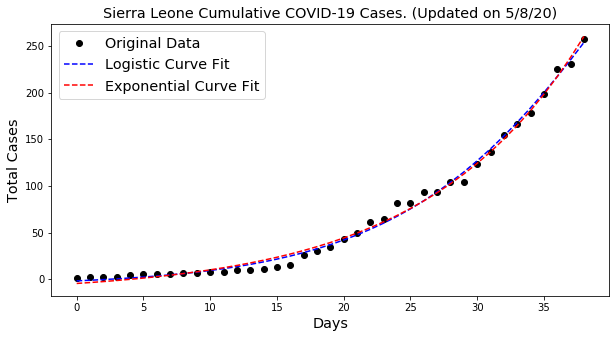



Benin

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 242
	Confirmed cases on 5/1/20 	 90
	Ratio: 2.69
	Weekly increase: 168.9 %
	Daily increase: 15.2 % per day
	Doubling Time (represents recent growth): 4.9 days


C:\OSGEO4~1\apps\Python37\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


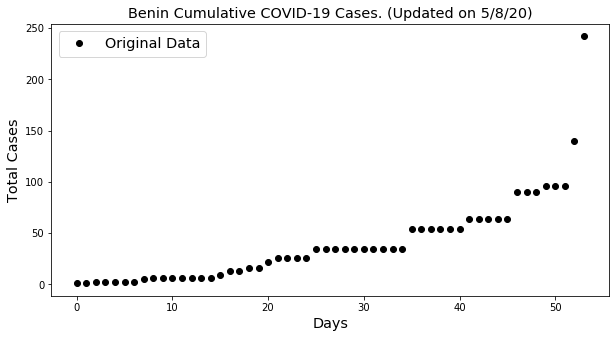



Cabo Verde

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 230
	Confirmed cases on 5/1/20 	 122
	Ratio: 1.89
	Weekly increase: 88.5 %
	Daily increase: 9.5 % per day
	Doubling Time (represents recent growth): 7.7 days

** Based on Logistic Fit**

	R^2: 0.980970953043554
	Doubling Time (during middle of growth):  14.47 (± 4.65 ) days

** Based on Exponential Fit **

	R^2: 0.9795146488641145
	Doubling Time (represents overall growth):  10.16 (± 1.21 ) days


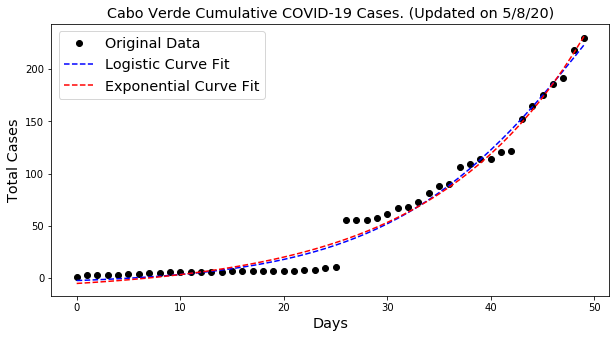



Sao Tome and Principe

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 208
	Confirmed cases on 5/1/20 	 16
	Ratio: 13.0
	Weekly increase: 1200.0 %
	Daily increase: 44.3 % per day
	Doubling Time (represents recent growth): 1.9 days


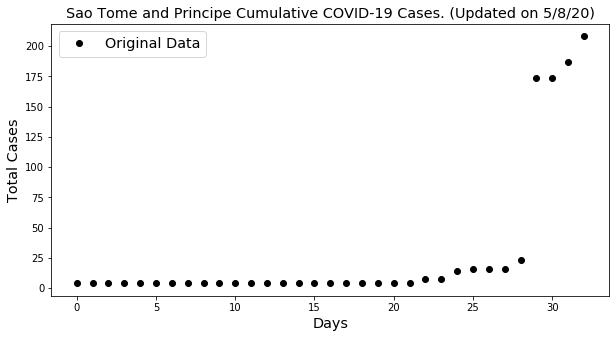



Liberia

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 199
	Confirmed cases on 5/1/20 	 152
	Ratio: 1.31
	Weekly increase: 30.9 %
	Daily increase: 3.9 % per day
	Doubling Time (represents recent growth): 18.0 days

** Based on Logistic Fit**

	R^2: 0.9917419961935617
	Doubling Time (during middle of growth):  12.14 (± 1.77 ) days

** Based on Exponential Fit **

	R^2: 0.9791789423087692
	Doubling Time (represents overall growth):  19.48 (± 3.42 ) days


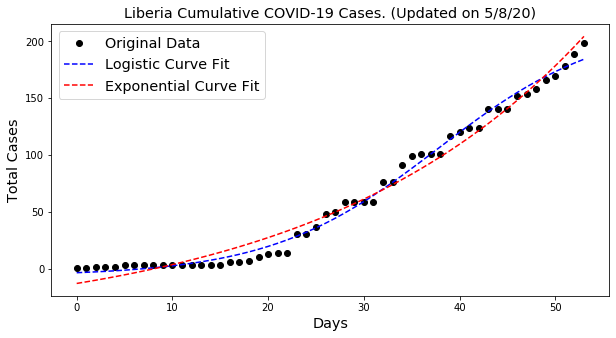



Ethiopia

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 194
	Confirmed cases on 5/1/20 	 133
	Ratio: 1.46
	Weekly increase: 45.9 %
	Daily increase: 5.5 % per day
	Doubling Time (represents recent growth): 12.9 days

** Based on Logistic Fit**

	R^2: 0.9786509169253501
	Doubling Time (during middle of growth):  19.23 (± 6.49 ) days

** Based on Exponential Fit **

	R^2: 0.9745405459174012
	Doubling Time (represents overall growth):  35.76 (± 11.17 ) days


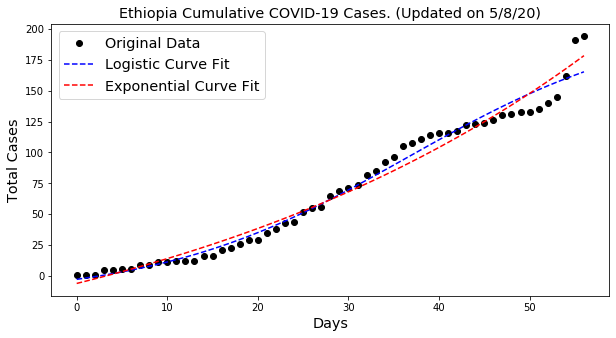



Madagascar

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 193
	Confirmed cases on 5/1/20 	 132
	Ratio: 1.46
	Weekly increase: 46.2 %
	Daily increase: 5.6 % per day
	Doubling Time (represents recent growth): 12.8 days

** Based on Logistic Fit**

	R^2: 0.9592491312962289
	Doubling Time (during middle of growth):  54.36 (± 115.4 ) days


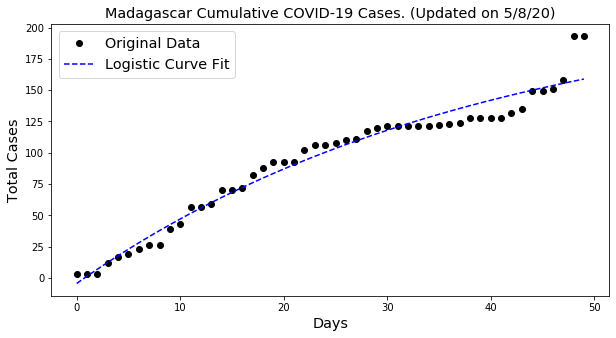



Burma

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 177
	Confirmed cases on 5/1/20 	 151
	Ratio: 1.17
	Weekly increase: 17.2 %
	Daily increase: 2.3 % per day
	Doubling Time (represents recent growth): 30.5 days

** Based on Logistic Fit**

	R^2: 0.992401942939923
	Doubling Time (during middle of growth):  5.75 (± 0.71 ) days


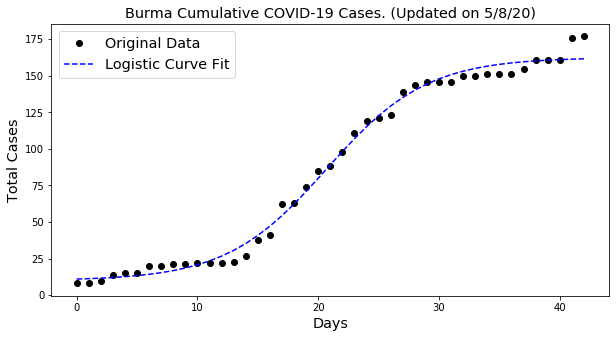



Zambia

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 167
	Confirmed cases on 5/1/20 	 109
	Ratio: 1.53
	Weekly increase: 53.2 %
	Daily increase: 6.3 % per day
	Doubling Time (represents recent growth): 11.4 days

** Based on Logistic Fit**

	R^2: 0.9762717257739291
	Doubling Time (during middle of growth):  30.93 (± 7.17 ) days

** Based on Exponential Fit **

	R^2: 0.9762717265008355
	Doubling Time (represents overall growth):  15.47 (± 2.53 ) days


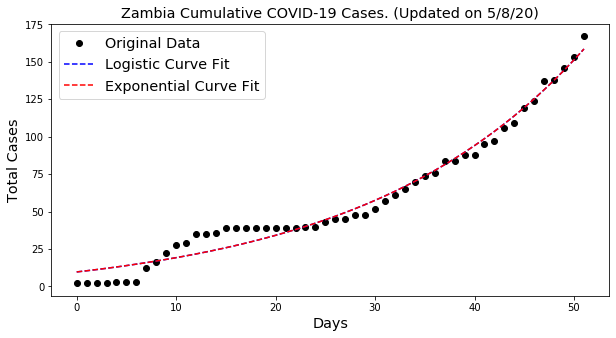



Eswatini

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 159
	Confirmed cases on 5/1/20 	 106
	Ratio: 1.5
	Weekly increase: 50.0 %
	Daily increase: 6.0 % per day
	Doubling Time (represents recent growth): 12.0 days

** Based on Logistic Fit**

	R^2: 0.9867496651120767
	Doubling Time (during middle of growth):  7.52 (± 1.21 ) days

** Based on Exponential Fit **

	R^2: 0.9768696532528482
	Doubling Time (represents overall growth):  7.76 (± 0.77 ) days


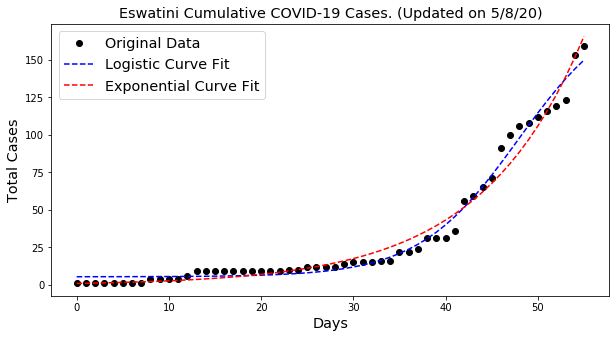



Haiti

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 146
	Confirmed cases on 5/1/20 	 85
	Ratio: 1.72
	Weekly increase: 71.8 %
	Daily increase: 8.0 % per day
	Doubling Time (represents recent growth): 9.0 days

** Based on Logistic Fit**

	R^2: 0.9764720153850871
	Doubling Time (during middle of growth):  36.3 (± 26.83 ) days

** Based on Exponential Fit **

	R^2: 0.976472017098174
	Doubling Time (represents overall growth):  18.15 (± 3.55 ) days


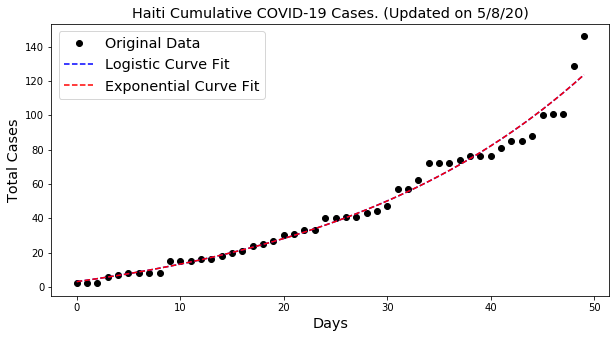



Togo

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 145
	Confirmed cases on 5/1/20 	 123
	Ratio: 1.18
	Weekly increase: 17.9 %
	Daily increase: 2.4 % per day
	Doubling Time (represents recent growth): 29.5 days

** Based on Logistic Fit**

	R^2: 0.9797067284458411
	Doubling Time (during middle of growth):  26.46 (± 10.71 ) days

** Based on Exponential Fit **

	R^2: 0.9752220245242229
	Doubling Time (represents overall growth):  45.79 (± 15.07 ) days


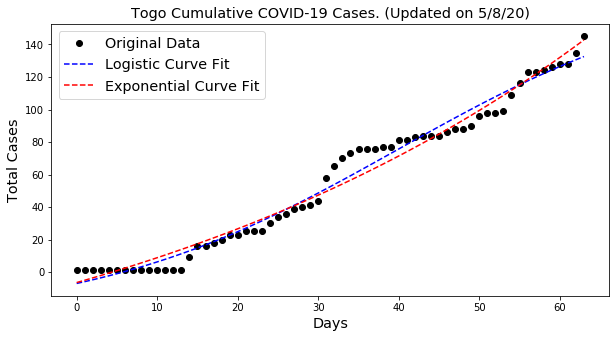



Central African Republic

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 143
	Confirmed cases on 5/1/20 	 72
	Ratio: 1.99
	Weekly increase: 98.6 %
	Daily increase: 10.3 % per day
	Doubling Time (represents recent growth): 7.1 days

** Based on Exponential Fit **

	R^2: 0.9617137659992648
	Doubling Time (represents overall growth):  5.4 (± 0.63 ) days


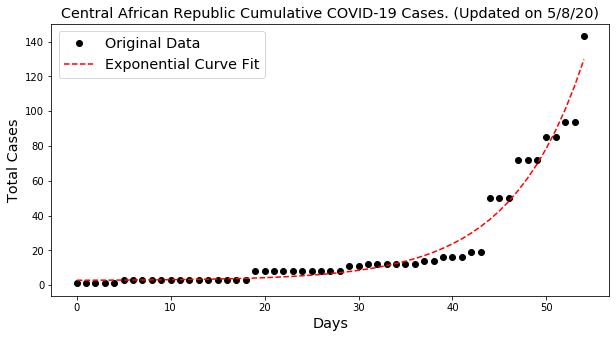



Brunei

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 141
	Confirmed cases on 5/1/20 	 138
	Ratio: 1.02
	Weekly increase: 2.2 %
	Daily increase: 0.3 % per day
	Doubling Time (represents recent growth): 225.6 days

** Based on Logistic Fit**

	R^2: 0.9947118981551737
	Doubling Time (during middle of growth):  8.29 (± 0.82 ) days


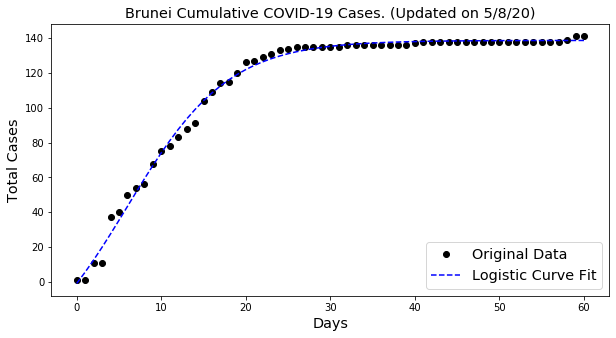



Cambodia

** Based on Logistic Fit**

	R^2: 0.9957602076442177
	Doubling Time (during middle of growth):  4.29 (± 0.35 ) days


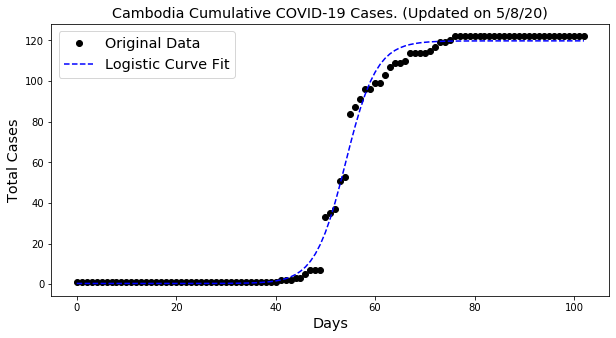



South Sudan

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 120
	Confirmed cases on 5/1/20 	 45
	Ratio: 2.67
	Weekly increase: 166.7 %
	Daily increase: 15.0 % per day
	Doubling Time (represents recent growth): 4.9 days


C:\OSGEO4~1\apps\Python37\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


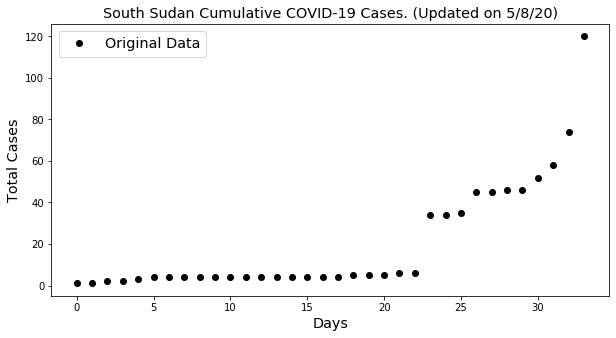



Trinidad and Tobago

** Based on Logistic Fit**

	R^2: 0.9864975609762223
	Doubling Time (during middle of growth):  8.05 (± 1.31 ) days


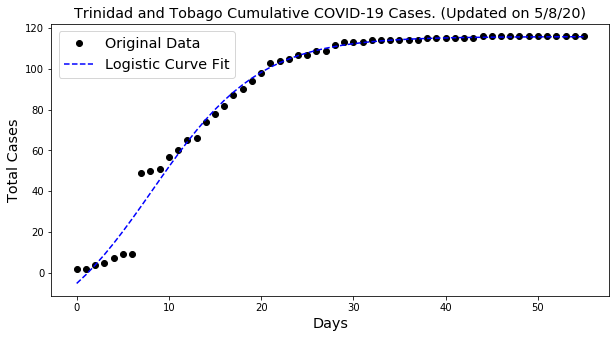



Nepal

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 102
	Confirmed cases on 5/1/20 	 59
	Ratio: 1.73
	Weekly increase: 72.9 %
	Daily increase: 8.1 % per day
	Doubling Time (represents recent growth): 8.9 days

** Based on Exponential Fit **

	R^2: 0.9807929173274637
	Doubling Time (represents overall growth):  9.97 (± 0.58 ) days


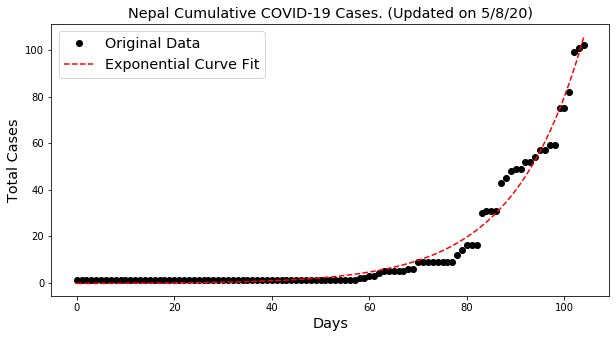



Uganda

** Based on Most Recent Week of Data **

	Confirmed cases on 5/8/20 	 101
	Confirmed cases on 5/1/20 	 85
	Ratio: 1.19
	Weekly increase: 18.8 %
	Daily increase: 2.5 % per day
	Doubling Time (represents recent growth): 28.1 days


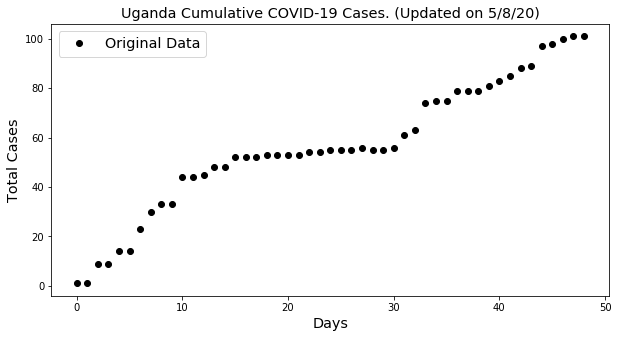

In [5]:
topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
print('\n')

for c in topcountries:
    print(c)
    a = plotCases(df, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

### Doubling Times for US COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


     Inferred Doubling Time  95%CI  Recent Doubling Time
0                      13.1    0.7                  32.0
1                       9.8    0.4                 112.3
2                      14.0    0.7                 105.6
3                      13.1    0.6                  27.9
4                      11.6    0.5                   9.8
..                      ...    ...                   ...
144                     4.3    0.4                   NaN
145                     NaN    NaN                   4.9
146                     8.1    1.3                   NaN
147                    10.0    0.6                   8.9
148                     NaN    NaN                  28.1

[149 rows x 3 columns]




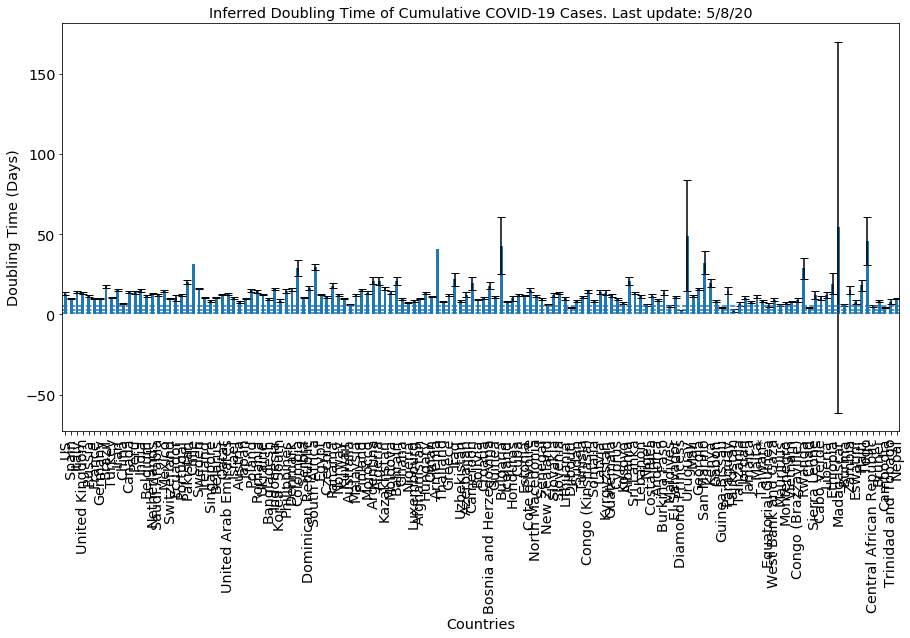

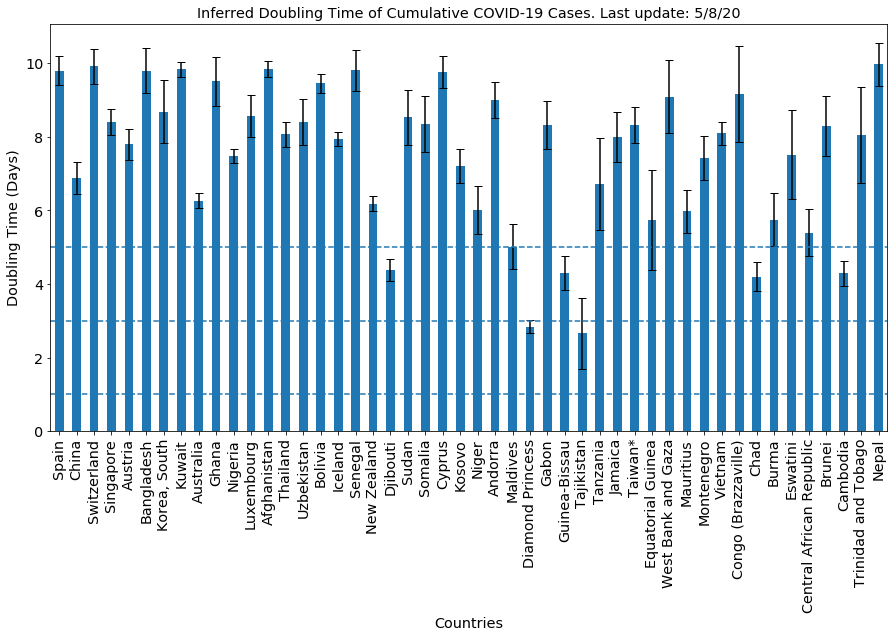

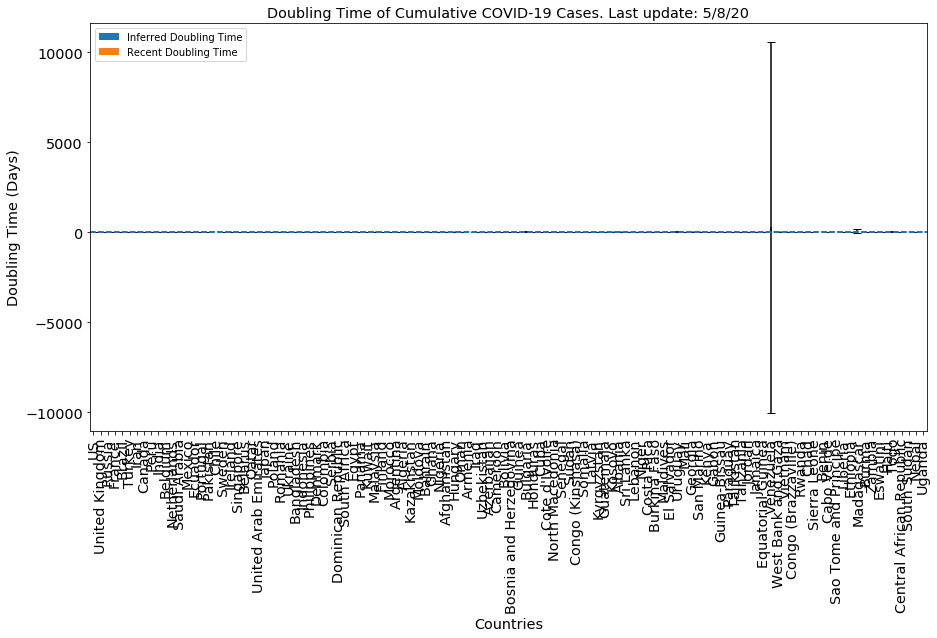

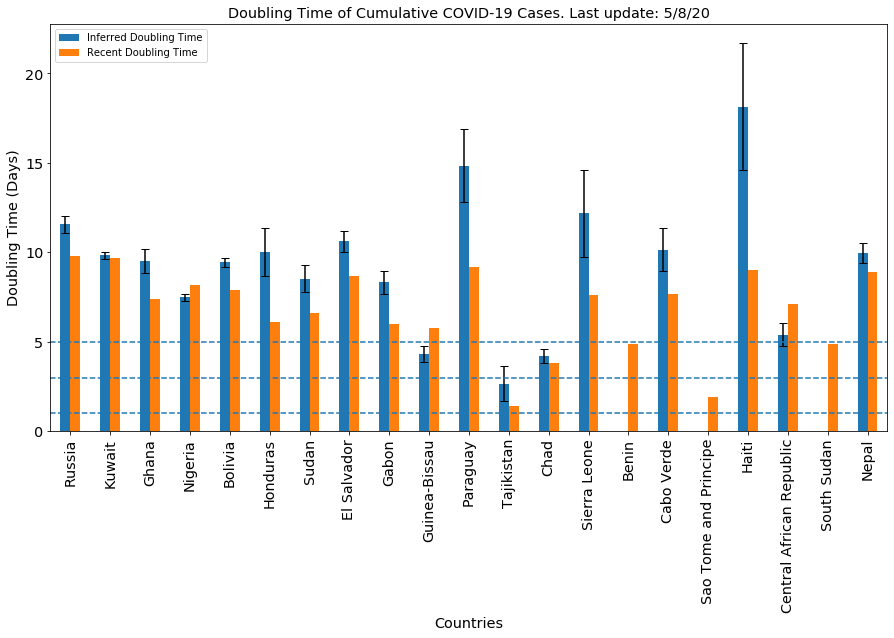

In [6]:
d = {'Countries': countries, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')

print(pd.DataFrame(data=d).iloc[:,[1,2,3]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 10]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=countries
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 10]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()